# Touristic Tour Recommendation Application
This notebook outlines the steps involved in creating an algorithm that generates a one-week itinerary for tourists in Algeria. The itinerary is optimized based on user preferences, proximity, and travel costs. Various search techniques, including **Uninformed Search Algorithms**, **A*** and **Hill Climbing**, are employed to create the optimal itinerary.


## Data Collection & Research
We gathered - clean - data about **+300 Algerian tourist attractions**, including the following attributes:
- **Attraction Name**
- **Type of Attraction** (museum, nature, beach, etc.)
- **City**
- **Cost** (entry fee)
- **Rating** (user rating)
- **GPS Coordinates** (latitude, longitude)
- **Description** (short description)


In [64]:
import json
from collections import Counter

DATA_PATH = "../Data/attractions.json"

with open(DATA_PATH, "r", encoding="utf-8") as f:
    attractions_data = json.load(f)
    

if not isinstance(attractions_data, list):
    raise ValueError("The JSON file does not contain a list of attractions.")

print("Number of attractions:", len(attractions_data))

# Count attractions per city
city_counts = Counter(attraction.get("city", "Unknown") for attraction in attractions_data)

# Count attractions per category
category_counts = Counter(attraction.get("category", "Unknown") for attraction in attractions_data)

print("\nNumber of attractions per city:")
for city, count in city_counts.items():
    print(f"{city}: {count}")

print("\nNumber of attractions per category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")


Number of attractions: 316

Number of attractions per city:
Algiers: 19
Tipaza: 5
Blida: 5
Médéa: 3
Oran: 17
Tlemcen: 9
Batna: 6
Béjaïa: 18
Constantine: 11
Djanet: 9
Sétif: 13
Annaba: 9
Guelma: 3
El Tarf: 7
Ghardaïa: 7
Tamanrasset: 7
Béchar: 3
Bouira: 7
El Bayadh: 1
Khenchela: 2
Biskra: 4
Timimoun: 6
El Oued: 3
M'Sila: 6
Tizi Ouzou: 21
Skikda: 6
Souk Ahras: 6
Tébessa: 6
Oum El-Bouaghi: 5
Jijel: 18
Aïn Témouchent: 10
Boumerdès: 5
Djelfa: 3
Naâma: 1
Mostaganem: 4
Aïn Defla: 3
Aïn Salah: 3
Bordj Badji Mokhtar: 3
El M'Ghair: 3
El Menia: 3
Relizane: 3
Saïda: 3
Sidi Bel Abbès: 3
Tiaret: 3
Tindouf: 2
Tissemsilt: 3
Touggourt: 3
Illizi: 2
In Guezzam: 2
In Salah: 2
Laghouat: 2
Mila: 2
Ouargla: 2
Bordj Bou Arréridj: 2
Adrar: 2

Number of attractions per category:
Garden: 7
Museum: 16
Cultural: 30
Historical: 63
Religious: 18
Amusement Park: 11
Shopping Mall: 6
Port: 2
Nature: 122
Lake: 7
Resort: 5
Beach: 29


## Data Hotel Collection & Research

We gathered and cleaned data about **+400 Algerian hotels** .  
This dataset contains valuable information to support various tasks such as:

- Recommendation systems
- Price analysis
- User satisfaction predictions

The dataset includes the following attributes:

- **Hotel Name**
- **City**
- **Price** (in DZD)
- **Average Review** (user rating)
- **GPS Coordinates** (latitude and longitude)

### Key Points
- **Cities covered**: Major Algerian cities and important tourist regions.
- **Price Range**: 4,000 DZD to 24,000 DZD per night.
- **Ratings Range**: 2.4 ★ to 5.0 ★.




In [65]:
import json
from collections import Counter

HOTELS_PATH = "../Data/cleaned_hotels.json"

with open(HOTELS_PATH, "r", encoding="utf-8") as f:
    hotels_data = json.load(f)

# Extract all city names
cities = [hotel['city'] for hotel in hotels_data]

# Count how many hotels per city
city_counts = Counter(cities)

# Display the results
for city, count in city_counts.items():
    print(f"{city}: {count} hotels")

# Total number of hotels
print(f"\nTotal number of hotels: {sum(city_counts.values())}")


Algiers: 58 hotels
Annaba: 43 hotels
Batna: 27 hotels
Béjaïa: 44 hotels
Constantine: 20 hotels
Ghardaïa: 21 hotels
Oran: 64 hotels
Sétif: 29 hotels
Tipaza: 18 hotels
Tlemcen: 31 hotels
Jijel: 14 hotels
Médéa: 10 hotels
Biskra: 26 hotels
Khenchela: 17 hotels
El Bayadh: 13 hotels
Bouira: 17 hotels
Adrar: 6 hotels
Timimoun: 1 hotels
Chlef: 7 hotels
Tébessa: 6 hotels
Tizi Ouzou: 6 hotels
Oum El Bouaghi: 5 hotels
Ain El Beida: 2 hotels
Aïn Defla: 7 hotels
Aïn Témouchent: 7 hotels
Bordj Bou Arréridj: 7 hotels
Boumerdès: 7 hotels
Djelfa: 7 hotels
Skikda: 7 hotels
Ouargla: 7 hotels
M'Sila: 7 hotels
In Salah: 7 hotels
Laghouat: 7 hotels
Béchar: 7 hotels
Blida: 7 hotels
Tamanrasset: 7 hotels
Tiaret: 7 hotels
Saïda: 7 hotels
Sidi Bel Abbès: 7 hotels
Guelma: 7 hotels
Mostaganem: 7 hotels
Mascara: 7 hotels
Illizi: 7 hotels
El Tarf: 7 hotels
Tindouf: 7 hotels
Tissemsilt: 7 hotels
El Oued: 7 hotels
Souk Ahras: 7 hotels
Mila: 7 hotels
Naâma: 7 hotels
Relizane: 7 hotels

Total number of hotels: 681


## 🏨 Hotel Selection System

### 🔹 Core Logic

Hotels are selected based on:
- **Location**: Chosen from the last attraction’s city each day
- **Budget**: 
  ```python
  max_per_night = (total_budget - attraction_costs) / 7
  ```
- **Preferences**: Star rating strictly followed, with fallback if needed

### 🔹 Workflow

**1. City Detection**
- Uses last visited city; if none, defaults to previous

**2. Filtering**
- **Strict pass**: city match, star range, price ≤ `max_per_night`
- **Fallback**: relaxed star filter, sorted by proximity to preference

**3. Recommendation**
- 3 options per city:
  - Budget (cheapest)
  - Balanced (median price)
  - Premium (highest)

### 🔹 Output Example

```plaintext
🏨 Day 3 - Constantine:
1. El Bey Hotel — 4.2★ — 8,100 DZD
2. Hotel Des Prince — 3.4★ ⚠️ — 9,900 DZD
3. Hostel le Rhumel — 4.5★ — 21,000 DZD
```

### 🔹 Smart Features

- **Budget Alerts**: Warns if attractions exceed budget
- **Fallback Logic**: Handles missing cities or hotel matches
- **Clear Mismatches**: Highlights if rating prefs aren’t met

### 🔹 Financial Overview

💰 Budget Breakdown:
- Total: 150,000 DZD
- Attractions: 6,317 DZD
- Hotels: ~71,799 DZD
- Remaining: ~71,884 DZD

### 🔹 Integration & UX

- **State Separation**: Hotels handled independently from attractions
- **Error Messages**: For budget/rating/city issues
- **User Tips**: Offers solutions for constraint conflicts



## Problem Formulation
### 1. State Representation

Our state representation is a dictionary with the following structure:

```python
state = {
    'current_location': (lat, lon),         # Current GPS coordinates
    'itinerary': [[] for _ in range(7)],    # 7 days of planned attractions (names)
    'curr_day': 0,                          # Current day index (0-6)
    'total_cost': 0,                        # Accumulated cost so far
    'total_time': 0,                        # Total travel time
    'daily_time': [0]*7                     # Time used per day (including visits)
    'daily_distance' : [0.0]*7
}
```

### 2. Actions

Two possible actions:
1. `('add', attraction)`: Add an attraction to the current day
2. `('next_day',)`: Move to the next day of planning

### 3. Goal Test

The goal is reached when:
- All 7 days have been planned (`curr_day >= 7`)
- Each day has at least one attraction

### 4. Path Cost

The path cost is the cumulative cost of visiting attractions and traveling between them.

### Problem Class
Now, let's define the main Problem class that will encapsulate our tour planning problem

In [66]:
import math
import json
import random
import re
from copy import deepcopy
from typing import List, Dict, Tuple  # Helper library for type hinting

class TourPlanningProblem:
    def __init__(self, initial_state: Dict, attractions: List[Dict],
                 user_prefs: Dict, constraints: Dict):
        """
        Args:
            initial_state: Initial state dictionary.
            attractions: List of attraction dictionaries.
            user_prefs: User preferences dictionary.
            constraints: Problem constraints dictionary.
        """
        self.initial_state = initial_state
        self.attractions = attractions
        self.user_prefs = user_prefs
        self.constraints = constraints

        # constant‑time lookup for any attraction name
        self._att_by_name = {a['name']: a for a in self.attractions}

        # cheaper if the user has a car
        self.dzd_per_km = 6.0 if constraints.get("has_car", False) else 10.0

        self.distance_cache = self._build_distance_cache()

    def _build_distance_cache(self) -> Dict[Tuple[str, str], float]:
        """Precompute distances between all pairs of attractions.
            store only upper‑triangle to halve the size"""
        cache = {}
        names = [a['name'] for a in self.attractions]
        for i, a1 in enumerate(self.attractions):
            for j in range(i + 1, len(self.attractions)):
                a2 = self.attractions[j]
                d = self._calculate_distance(a1['gps'], a2['gps'])
                cache[(a1['name'], a2['name'])] = d
                cache[(a2['name'], a1['name'])] = d          # mirror
        return cache

    @staticmethod
    def _calculate_distance(coord1: List[float], coord2: List[float]) -> float:
        """
        Haversine distance (km) between two GPS coordinates.
        """
        lat1, lon1 = map(math.radians, coord1)
        lat2, lon2 = map(math.radians, coord2)
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = (math.sin(dlat / 2)**2 +
             math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2)
        return 6371 * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    def actions(self, state: Dict) -> List[Tuple]:
        """
        Return a list of possible actions from the current state.
        Two types of actions:
          - ('add', <attraction_dict>): add an attraction to the current day.
          - ('next_day',): move to the next day.
        """
        valid_actions = []
        curr_day = state['curr_day']

        # If all days are planned, no further actions
        if curr_day >= len(state['itinerary']):
            return []

        # If the current day is full, only allow moving to next day
        if len(state['itinerary'][curr_day]) >= self.constraints['max_attractions_per_day']:
            return [('next_day',)]

        preferred = set(self.user_prefs.get('categories', []))

        # Check each attraction for validity
        for att in self.attractions:
            if att['category'] not in preferred:                 # ← preference filter
                continue
            if self._is_valid_addition(state, att):
                valid_actions.append(('add', att))

        # Allow 'next_day' if there's at least one attraction in the current day
        if len(state['itinerary'][curr_day]) > 0:
            valid_actions.append(('next_day',))

        return valid_actions

    def _is_valid_addition(self, state: Dict, attraction: Dict) -> bool:
        curr_day = state['curr_day']
        if curr_day >= 7:
            return False

        # 1) duplicates & per-day limit
        if any(attraction['name'] in day for day in state['itinerary']):
            return False
        if len(state['itinerary'][curr_day]) >= self.constraints['max_attractions_per_day']:
            return False

        # 2) compute travel / visit metrics once
        distance_km  = self._calculate_distance(state['current_location'], attraction['gps'])
        travel_time  = distance_km / 50          # ← avg 50 km/h
        visit_time   = self._parse_duration(attraction['visit_duration'])
        ticket_cost  = self._parse_cost(attraction['cost'])
        travel_cost  = self.travel_cost_km(state['current_location'], attraction['gps'])

        # 3) global budget cap  (✓ Bug 2.1 fixed)
        budget_cap = self.constraints.get("max_total_budget")
        if budget_cap is not None:
            prospective = state['total_cost'] + ticket_cost + travel_cost
            if prospective > budget_cap:
                return False

        # 4) daily time cap
        if state['daily_time'][curr_day] + travel_time + visit_time > self.constraints['max_daily_time']:
            return False

        # 5) optional daily-distance cap  (✓ Bug 2.2 fixed)
        max_dist = self.constraints.get("max_daily_distance")
        if max_dist is not None:
            if state['daily_distance'][curr_day] + distance_km > max_dist:
                return False

        return True

    def _estimate_travel_time(self, state: Dict, new_attraction: Dict) -> float:
        """
        Estimate travel time from the last visited attraction (or current location)
        to the new attraction.
        Assumes an average speed of 50 km/h.
        """
        curr_day = state['curr_day']
        day_attractions = state['itinerary'][curr_day]

        if not day_attractions:
            last_coords = state['current_location']
        else:
            last_att_name = day_attractions[-1]
            last_att = next(a for a in self.attractions if a['name'] == last_att_name)
            last_coords = last_att['gps']

        distance = self._calculate_distance(last_coords, new_attraction['gps'])
        return distance / 50  # hours

    def result(self, state: Dict, action: Tuple) -> Dict:
        new_state = deepcopy(state)
        action_type = action[0]
        curr_day = new_state['curr_day']

        if action_type == 'add':
            _, attraction = action

            # compute distance between previous location and new attraction
            distance_km = self._calculate_distance(
                new_state['current_location'], attraction['gps']
            )
            # track daily distance
            new_state['daily_distance'][curr_day] += distance_km

            ticket_cost  = self._parse_cost(attraction['cost'])
            travel_cost  = self.travel_cost_km(new_state['current_location'], attraction['gps'])
            new_state['total_cost'] += ticket_cost + travel_cost

            # compute travel & visit durations
            travel_time = self._estimate_travel_time(state, attraction)
            visit_time  = self._parse_duration(attraction['visit_duration'])

            new_state['daily_time'][curr_day] += travel_time + visit_time
            new_state['total_time']           += travel_time + visit_time

            new_state['itinerary'][curr_day].append(attraction['name'])
            new_state['current_location'] = attraction['gps']

        elif action_type == 'next_day':
            new_state['curr_day'] += 1

        return new_state

    def path_cost(self, current_cost: float, state1: Dict,
                  action: Tuple, state2: Dict) -> float:
        """
        For every node, path_cost == state['total_cost'] (in dinars).
        We **never** add the leg cost here – `result()` has already done it.
        """
        return state2['total_cost']

    def travel_cost_km(self, gps_a: List[float], gps_b: List[float]) -> float:
        """Return travel money (DZD) between two points."""
        dist = self._calculate_distance(gps_a, gps_b)
        return dist * self.dzd_per_km

    def is_goal(self, state: Dict) -> bool:
        """
        The goal is reached if:
         1) We have planned all 7 days (curr_day >= 7).
         2) Each day has at least one attraction.
         3) The total cost is within budget.
        """
        if state['curr_day'] < 7:
            return False
        for day_list in state['itinerary']:
            if len(day_list) == 0:
                return False
        if state['total_cost'] > self.constraints['max_total_budget']:
            return False
        return True

    def value(self, state: Dict) -> float:
        """
        Compute an overall quality score for a complete itinerary state.

        The final score is:

            satisfaction (0–100)
          − budget penalty (0–100)
          − time penalty   (0–50)
          − distance penalty (0–50)

        1. Satisfaction: how well the chosen attractions match user preferences,
           normalized to 0–100 via `_calculate_satisfaction`.
        2. Budget penalty: if total_cost exceeds the weekly budget, we impose
           up to −100 points proportional to the overspend.
        3. Time penalty: if total daily hours exceed 7×max_daily_time, up to −50 points.
        4. Distance penalty: if total travel kilometers exceed 50 km/h×max_daily_time×7,
           up to −50 points (captures excessive driving).

        Returns
        -------
        float
            A single scalar: higher means a better, more “satisfying” and feasible
            itinerary.
        """
        # 1) base satisfaction 0–100
        sat = self._calculate_satisfaction(state)

        # 2) budget penalty up to −100
        max_b = self.constraints.get('max_total_budget') or 1
        over_b = max(0.0, state['total_cost'] - max_b)
        cost_pen = min(100.0, (over_b / max_b) * 100.0)

        # 3) time penalty up to −50
        max_t = self.constraints['max_daily_time'] * 7
        over_t = max(0.0, sum(state['daily_time']) - max_t)
        time_pen = min(50.0, (over_t / max_t) * 50.0)

        # 4) distance penalty up to −50
        max_d = 50 * self.constraints['max_daily_time'] * 7
        over_d = max(0.0, sum(state['daily_distance']) - max_d)
        dist_pen = min(50.0, (over_d / max_d) * 50.0)

        return sat - cost_pen - time_pen - dist_pen


    def _calculate_satisfaction(self, state: Dict) -> float:
        """
        Compute a 0–100 “satisfaction” score based solely on user-preferred attractions.

        For each visited attraction:
        - +10×rating if it belongs to a preferred category
        - +5×rating otherwise

        The raw sum is then divided by the “ideal” maximum:
            10 points × max_rating (5) × 7 days × max attractions per day
        to yield a percentage in [0,100].

        Returns
        -------
        float
            How well the itinerary matches the user’s category/rating preferences.
        """
        score = 0.0
        preferred = set(self.user_prefs['categories'])

        for day in state['itinerary']:
            for name in day:
                a = self._att_by_name[name]
                weight = 10 if a['category'] in preferred else 5
                score += weight * a['rating']

        max_per_day = self.constraints['max_attractions_per_day']
        ideal_max = 10 * 5 * 7 * max_per_day
        return (score / ideal_max) * 100.0


    def _calculate_penalties(self, state: Dict) -> float:
        """
        Compute the sum of budget and time penalties, for diagnostic purposes.

        1. Budget penalty: (total_cost / max_total_budget) × 50
        2. Time penalty:   (sum(daily_time) / (7×max_daily_time)) × 30

        Returns
        -------
        float
            Combined penalty; higher means more severe violations of constraints.
        """
        cost_penalty = (state['total_cost'] / self.constraints['max_total_budget']) * 50
        time_penalty = (sum(state['daily_time']) /
                        (7 * self.constraints['max_daily_time'])) * 30
        return cost_penalty + time_penalty

    @staticmethod
    def _parse_cost(cost_str: str) -> float:
        """
        Convert cost field (e.g., "Free", "400 DZD", "Variable") to a numeric value.
        - "free" -> 0
        - "variable" or any non‑numeric -> 0
        - Otherwise, return the first number found.
        """
        s = cost_str.strip().lower()
        if "free" in s:
            return 0.0
        if "variable" in s:
            # treat Variable as zero cost, but later printed as "Variable", for e.g.: Shopping Malls (not implemented yet tho)
            return 0.0
        m = re.search(r"(\d+(?:\.\d+)?)", s)
        if m:
            return float(m.group(1))
        # fallback: everything else counts as zero
        return 0.0

    @staticmethod
    def _parse_duration(duration_str: str) -> float:
        """
        Convert a duration string (e.g., "1-2 hours", "0.5 hour", "3 hours") to a numeric estimate (hours).
        """
        duration_str = duration_str.lower().strip()
        # Matches "2 hours", "0.5 hour", "1-2 hours", etc.
        m = re.match(r"(\d+(?:\.\d+)?)(?:-(\d+(?:\.\d+)?))?\s*(?:h|hour|hrs?)", duration_str)
        if m:
            low = float(m.group(1))
            if m.group(2):
                high = float(m.group(2))
                return (low + high) / 2.0
            return low
        # Fallback if nothing matches
        return 2.0


### Node Class
First, let's define the Node class which will represent states in our search space:
A state represents a partial itinerary

In [67]:
class Node:
    def __init__(self, state: Dict, parent: 'Node' = None, 
                 action: Tuple = None, path_cost: float = 0):
        """
        Args:
            state: The current state dictionary
            parent: Parent node
            action: Action that led to this node
            path_cost: Cumulative cost to reach this node
        """
        self.state = deepcopy(state)
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = parent.depth + 1 if parent else 0
        self.value = None  # Will store heuristic/objective value
        
    def __lt__(self, other: 'Node') -> bool:
        """
        For priority queue ordering if needed (like in A*).
        If self.value is None, defaults to 0 for comparison.
        """
        return self.value < other.value if self.value is not None else False
        
    def expand(self, problem: TourPlanningProblem) -> List['Node']:
        """Generate all child nodes reachable from this node"""
        child_nodes = []
        for action in problem.actions(self.state):
            next_state = problem.result(self.state, action)
            child_node = Node(
                state=next_state,
                parent=self,
                action=action,
                path_cost=problem.path_cost(self.path_cost, self.state, action, next_state)
            )
            child_nodes.append(child_node)
        return child_nodes
        
    def path(self) -> List['Node']:
        """Return the path from root to this node"""
        node, path = self, []
        while node:
            path.append(node)
            node = node.parent
        return list(reversed(path))
        
    def __repr__(self) -> str:
        return (f"Node(day={self.state['curr_day']}, "
                f"cost={self.state['total_cost']}, "
                f"value={self.value})")
    
    def __eq__(self, other: 'Node') -> bool:
        """
        Equality check based on the state's itinerary and day.
        """
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self) -> int:
        """
        Hash based on the itinerary's arrangement for use in sets/dicts.
        """
        # We'll hash a tuple of (current_day, tuple of each day’s attractions).
        # This avoids collisions from dict ordering
        day_tuples = tuple(tuple(day) for day in self.state['itinerary'])
        return hash((self.state['curr_day'], day_tuples))
    def generate_neighbors(self, problem: 'TourPlanningProblem') -> List['Node']:
        """
        Generate all possible neighbors by swapping, removing, or adding attractions
        for each day of the itinerary, respecting the problem constraints.

        Args:
            problem (TourPlanningProblem): The problem instance that holds the data for attractions and constraints.

        Returns:
            List[Node]: A list of neighboring nodes.
        """
        neighbors = []
        current_state = self.state
        attractions = problem.attractions
        constraints = problem.constraints

        for day_idx in range(7):  # Iterate over the 7 days
            day = current_state['itinerary'][day_idx]

            # ---- SWAP Attractions within a Day ----
            if len(day) > 1:  # If more than one attraction for the day, we can swap
                for i in range(len(day)):
                    for j in range(i + 1, len(day)):
                        new_state = deepcopy(current_state)
                        new_day = new_state['itinerary'][day_idx]
                        new_day[i], new_day[j] = new_day[j], new_day[i]

                        # Find the actual attraction dictionaries based on the names
                        attraction_i = next((att for att in attractions if att['name'] == new_day[i]), None)
                        attraction_j = next((att for att in attractions if att['name'] == new_day[j]), None)

                        # Check if the new state is valid before creating a child node
                        if attraction_i and attraction_j and \
                        problem._is_valid_addition(new_state, attraction_i) and \
                        problem._is_valid_addition(new_state, attraction_j):
                            child_node = Node(
                                state=new_state,
                                parent=self,
                                action=("swap", day_idx, i, j),
                                path_cost=self.path_cost  # Update if cost changes
                            )
                            neighbors.append(child_node)

            # ---- REMOVE Attraction ----
            for i in range(len(day)):
                new_state = deepcopy(current_state)
                removed_name = new_state['itinerary'][day_idx].pop(i)

                removed_attr = next(a for a in attractions if a['name'] == removed_name)
                new_state['total_cost'] -= problem._parse_cost(removed_attr['cost'])
                new_state['daily_time'][day_idx] -= problem._parse_duration(removed_attr['visit_duration'])
                new_state['total_time'] -= problem._parse_duration(removed_attr['visit_duration'])  # Update total time

                # Check if the new state is valid after removal
                if new_state['total_cost'] <= constraints['max_total_budget']:
                    child_node = Node(
                        state=new_state,
                        parent=self,
                        action=("remove", day_idx, removed_name),
                        path_cost=self.path_cost  # Update if needed
                    )
                    neighbors.append(child_node)

            # ---- ADD a New Attraction ----
            for att in attractions:
                if att['name'] in current_state['itinerary'][day_idx]:
                    continue  # Avoid duplicates

                new_state = deepcopy(current_state)
                if problem._is_valid_addition(new_state, att):  # Check if addition is valid
                    new_state['itinerary'][day_idx].append(att['name'])
                    new_state['total_cost'] += problem._parse_cost(att['cost'])
                    travel_time = problem._estimate_travel_time(current_state, att)
                    visit_time = problem._parse_duration(att['visit_duration'])
                    new_state['daily_time'][day_idx] += travel_time + visit_time
                    new_state['total_time'] += travel_time + visit_time  # Update total time

                    # Check if the new state is valid after addition
                    if (new_state['daily_time'][day_idx] <= constraints['max_daily_time'] and
                        new_state['total_cost'] <= constraints['max_total_budget']):
                        child_node = Node(
                            state=new_state,
                            parent=self,
                            action=("add", day_idx, att['name']),
                            path_cost=self.path_cost  # Update if needed
                        )
                        neighbors.append(child_node)

        return neighbors
    def generate_random_solution(self, problem: 'TourPlanningProblem') -> dict:
        """
        Generate a random initial solution for the tour planning problem.

        Args:
            problem: The tour planning problem instance.

        Returns:
            A random state representing a potential solution.
        """
        random_state = {
            'curr_day': 0,
            'itinerary': [[] for _ in range(7)],
            'total_cost': 0.0,
            'total_time': 0.0,
            'daily_time': [0.0 for _ in range(7)],
            'current_location': problem.initial_state['current_location'],
        }

        used_attractions = set()
        max_daily_time = problem.constraints['max_daily_time']
        max_total_budget = problem.constraints['max_total_budget']
        max_attractions_per_day = problem.constraints['max_attractions_per_day']

        for day in range(7):
            day_time = 0.0
            day_cost = 0.0
            attractions_today = 0

            while day_time < max_daily_time and attractions_today < max_attractions_per_day:
                # Create a list of candidates that haven't been used yet
                candidates = [
                    att['name'] for att in problem.attractions
                    if att['name'] not in used_attractions 
                ]
                if not candidates:
                    break  # No more candidates available

                # Randomly select an attraction from the candidates
                selected_name = random.choice(candidates)
                selected_attraction = next(att for att in problem.attractions if att['name'] == selected_name)
                visit_time = problem._parse_duration(selected_attraction['visit_duration'])
                attraction_cost = problem._parse_cost(selected_attraction['cost'])

                # Check if adding this attraction exceeds the daily time limit or total budget
                if day_time + visit_time > max_daily_time or day_cost + attraction_cost > max_total_budget:
                    break

                # Update the random state with the selected attraction
                random_state['itinerary'][day].append(selected_name)
                used_attractions.add(selected_name)
                day_cost += attraction_cost
                day_time += visit_time
                random_state['daily_time'][day] += visit_time
                random_state['total_time'] += visit_time
                random_state['total_cost'] += attraction_cost
                random_state['current_location'] = selected_attraction['gps']  # Update current location
                attractions_today += 1  # Increment the count of attractions for today

        return random_state
    def get_best(self,neighbors_list: List['Node'], problem: 'TourPlanningProblem') -> Tuple['Node', float]:
        """
        Get the neighbor with the best evaluation value.

        Args:
            neighbors_list: A list of Node instances.
            problem: Instance of TourPlanningProblem to evaluate nodes.

        Returns:
            A tuple of (best Node, its value)
        """
        best_value = float('-inf')
        best_node = None 

        for node in neighbors_list:
            # Compute or retrieve value
            if node.value is None:
                node.value = problem.value(node.state)

            if node.value > best_value:
                best_value = node.value
                best_node = node

        return best_node, best_value
    def suggest_hotels(self, problem, hotels_data, attractions_data):
        """Suggest hotels for the current itinerary"""
        return find_hotels_for_itinerary(
            self.state['itinerary'],
            attractions_data,
            hotels_data,
            problem.constraints['max_total_budget'],
            self.state['total_cost']
        ) 



## Helper Functions

In [68]:
import math
from typing import List, Tuple, Dict
import json
def load_attractions(json_file: str) -> List[Dict]:
    """Load attractions from JSON file"""
    with open(json_file) as f:
        return json.load(f)   #not needed 

def create_initial_state(start_location: Tuple[float, float], user_prefs: Dict) -> Dict:
    """Create initial state dictionary"""
    return {
        'current_location': start_location,
        'itinerary': [[] for _ in range(7)],
        'curr_day': 0,
        'total_cost': 0.0,
        'total_time': 0.0,
        'daily_time': [0.0]*7,
        'daily_distance': [0.0]*7          # ← new
    }

def estimate_travel_time(distance_km: float,
                        transport_mode: str = 'car') -> float:
    """Convert distance to estimated travel time in hours"""
    speeds = {'car': 50, 'bus': 40, 'walking': 5}
    return distance_km / speeds.get(transport_mode, 50)

def calculate_day_time(itinerary_day: List[str],
                     attractions: List[Dict],
                     distance_matrix: Dict) -> float:
    """Calculate total time for a single day's itinerary"""
    total_time = 0
    for i in range(len(itinerary_day)):
        if i > 0:
            prev_att = next(a for a in attractions if a['name'] == itinerary_day[i-1])
            curr_att = next(a for a in attractions if a['name'] == itinerary_day[i])
            distance = distance_matrix[(prev_att['name'], curr_att['name'])]
            total_time += estimate_travel_time(distance)
        # Note: to be adjusted if we need to look up the visit duration for the current attraction
        total_time += TourPlanningProblem._parse_duration(curr_att['visit_duration'])
    return total_time

def calculate_total_cost(itinerary: List[List[str]],
                       attractions: List[Dict]) -> float:
    """Calculate total cost of itinerary"""
    return sum(TourPlanningProblem._parse_cost(a['cost'])
              for day in itinerary
              for att_name in day
              for a in attractions if a['name'] == att_name)

def estimate_hotel_costs(hotel_standard: Tuple[int, int],
                        num_nights: int = 7) -> float:
    """Estimate hotel costs based on preferred star rating"""
    min_stars, max_stars = hotel_standard
    avg_stars = (min_stars + max_stars) / 2
    # Assuming 3000 DZD per night per star
    return avg_stars * 3000 * num_nights



def find_hotels_for_itinerary(itinerary, attractions_data, hotels_data, total_budget, spent_cost, min_stars=3, max_stars=5):
    """
    Find suitable hotels for cities in the itinerary within remaining budget.
    Returns a dictionary mapping days to list of suitable hotels (cheapest, middle, most expensive).
    Also returns the average total hotel cost.
    """
    # Calculate remaining budget and max price per night
    remaining_budget = total_budget - spent_cost
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    hotels_by_day = {}
    total_hotel_cost = 0
    
    # Early warning if budget is exhausted
    if remaining_budget <= 0:
        print("⚠️ Budget Warning: All funds have been spent on attractions - no budget left for hotels")
        return {}, 0
    
    for day_idx in range(7):
        # Get city of last attraction that day
        day_city = None
        if day_idx < len(itinerary) and itinerary[day_idx]:
            last_att_name = itinerary[day_idx][-1]
            last_att = next((a for a in attractions_data if a['name'] == last_att_name), None)
            if last_att:
                day_city = last_att['city']
        
        if not day_city:
            # If no attractions that day, use previous day's city
            for d in range(day_idx-1, -1, -1):
                if d in hotels_by_day:
                    day_city = hotels_by_day[d][0]['city']
                    break
        
        if day_city:
            # Find suitable hotels in this city with strict star rating first
            suitable_hotels = [
                hotel for hotel in hotels_data 
                if hotel['city'].lower() == day_city.lower()
                and min_stars <= hotel['avg_review'] <= max_stars
                and hotel['price'] <= max_price_per_night
            ]
            
            # If none found, relax the star rating constraint
            if not suitable_hotels:
                suitable_hotels = [
                    hotel for hotel in hotels_data 
                    if hotel['city'].lower() == day_city.lower()
                    and hotel['price'] <= max_price_per_night
                ]
                # Sort by closest to desired star rating
                suitable_hotels.sort(key=lambda x: abs(x['avg_review'] - (min_stars + max_stars)/2))
                
                if not suitable_hotels:
                    print(f"⚠️ No hotels found in {day_city} within {max_price_per_night:.0f} DZD/night (even without star rating filter)")
                    continue
                else:
                    print(f"ℹ️ Found hotels in {day_city} but none match your {min_stars}-{max_stars} star preference")
                    print("   Showing best available options regardless of rating")
            
            # Sort by price
            suitable_hotels.sort(key=lambda x: x['price'])
            
            # Select 3 hotels: cheapest, middle, most expensive
            selected_hotels = []
            if len(suitable_hotels) >= 3:
                selected_hotels = [
                    suitable_hotels[0],  # cheapest
                    suitable_hotels[len(suitable_hotels)//2],  # middle
                    suitable_hotels[-1]  # most expensive
                ]
            elif suitable_hotels:
                selected_hotels = suitable_hotels
            
            if selected_hotels:
                # Calculate average price for these hotels
                avg_price = sum(h['price'] for h in selected_hotels) / len(selected_hotels)
                total_hotel_cost += avg_price
                
                hotels_by_day[day_idx+1] = selected_hotels
    
    # Final summary of hotel findings
    if not hotels_by_day:
        print("\n❌ No suitable hotels found for your entire itinerary")
        print(f"   Visited cities: {', '.join(set(a['city'] for day in itinerary for a in attractions_data if a['name'] in day))}")
        print(f"   Max price per night: {max_price_per_night:.0f} DZD")
        print(f"   Star preference: {min_stars}-{max_stars} stars")
    else:
        missing_days = [d for d in range(1,8) if d not in hotels_by_day]
        if missing_days:
            print(f"\n⚠️ Note: No hotels found for day(s) {', '.join(map(str, missing_days))}")
    
    return hotels_by_day, total_hotel_cost




## User Preferences Simulation 
The application will take inputs (from the website interface) such as:
- **Starting location**: Algiers
- **Preferred attractions**: Museums, Historical Sites
- **Budget**: 5000 DZD
- **Hotel rating**: 3 stars (Suggested :  add a MAX and MIN for the hotel rating)


## Search Algorithm Implementations

In this project, we use a combination of **uninformed search algorithms** (BFS, DFS) and **informed search algorithms** (A\* Search, Hill Climbing) to generate the optimal itinerary based on cost, proximity, and user preferences.

Each search algorithm has its strengths and weaknesses. In this section, we will implement and compare their performance in solving the itinerary optimization problem.


### DFS
Explores each path as deep as possible before backtracking, often used when exploring solutions in a depth-first manner.

In [69]:
def depth_limited_search(problem: TourPlanningProblem, limit: int):
    """
    A Depth-Limited Search on the TourPlanningProblem.

    :param problem: An instance of the TourPlanningProblem.
    :param limit: Maximum depth (or 'depth limit') for the search.
    :return: The first solution Node that satisfies problem.is_goal(...) or None if no solution is found
             within the specified depth limit.
    """
    # We'll define a recursive inner function that carries the explored set and the current depth as we go deeper.
    def recursive_dls(node: Node, depth: int, explored):
        if problem.is_goal(node.state):
            return node

        if depth == limit:
            return None  # We've reached the depth limit, stop going deeper.

        explored.add(node)

        # Expand the node
        for child in node.expand(problem):
            if child not in explored:
                result = recursive_dls(child, depth + 1, explored)
                if result is not None:
                    return result
        return None

    initial_node = Node(problem.initial_state)

    if problem.is_goal(initial_node.state):
        return initial_node

    explored_set = set()

    return recursive_dls(initial_node, 0, explored_set)


def depth_first_search(problem: TourPlanningProblem, max_depth: int = None):
    """
    Depth-First Search for the TourPlanningProblem.
    If max_depth is None, we use a very large limit (effectively 'no limit').
    """
    if max_depth is None:
        max_depth = 999999  # effectively no limit

    return depth_limited_search(problem, max_depth)

def iterative_deepening_search(problem: TourPlanningProblem, max_depth: int = 30):
    """
    Iterative Deepening DFS: Repeatedly run depth-limited DFS up to increasing depth limits.

    :param problem: An instance of TourPlanningProblem.
    :param max_depth: Maximum depth up to which we'll attempt searches.
    :return: The first solution Node found, or None if no solution is found up to max_depth.
    """
    for depth in range(max_depth + 1):
        result = depth_limited_search(problem, depth)
        if result is not None:
            return result
    return None

### Example Executing DFS

In [70]:
def run_DFS_demo() -> None:
    """Depth‑first demo with hotel suggestions"""
    # 1. scenario settings (unchanged)
    constraints = {
        "max_total_budget": 150000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Beach", "Historical", "Museum", "Shopping Mall"],
        "hotel_stars": (3, 5)  # Add hotel preferences
    }

    initial_state = {
        "current_location": (36.737232, 3.086472),   # Algiers
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs  # Add preferences to state
    }

    # 2. build problem & search (unchanged)
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = depth_first_search(problem, max_depth=40)
    if goal is None:
        print("DFS ❌ No itinerary found within the depth limit.")
        return

    # Find hotels for the complete itinerary
    hotels_by_day, total_hotel_cost = find_hotels_for_itinerary(
        goal.state['itinerary'],
        attractions_data,
        hotels_data,
        constraints['max_total_budget'],
        goal.state['total_cost'],
        user_prefs['hotel_stars'][0],
        user_prefs['hotel_stars'][1]
    )
    goal.state['hotels'] = hotels_by_day

    # 3. pretty trace of the path (unchanged)
    print("DFS ✅ itinerary found with hotel suggestions\n")
    path = goal.path()            # root … goal
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for node in path[1:]:         # skip root
        act = node.action
        if act[0] == "add":
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])
            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att['name']}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == "next_day":
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0

    if goal.action and goal.action[0] != "next_day":
        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries (unchanged)
    st = goal.state
    print("📊 Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        day_total_dz = sum(problem._parse_cost(a["cost"])
                       for a in attractions_data
                       if a["name"] in lst)
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {day_total_dz:4.0f} DZD -> {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱ Search depth : {goal.depth}")

    # 5. Enhanced Hotel Recommendations Section
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    print(f"💰 Budget Overview:")
    print(f"   - Total budget: {constraints['max_total_budget']:.0f} DZD")
    print(f"   - Spent on attractions: {st['total_cost']:.0f} DZD")
    print(f"   - Remaining for hotels: {remaining_budget:.0f} DZD")
    print(f"   - Max per night: {max_price_per_night:.0f} DZD")
    print(f"   - Your star preference: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars")

    if remaining_budget <= 0:
        print("\n⚠️ Budget Alert: You've exhausted your entire budget on attractions")
        print("   No funds remaining for hotel accommodations")
        return

    if not hotels_by_day:
        print("\n❌ No suitable hotels found matching all your criteria")
        print("\nPossible reasons:")
        print("- No hotels in visited cities meet your star rating preference")
        print("- Hotel prices exceed your remaining budget")
        print("\nSuggestions:")
        print(f"1. Increase your total budget (current: {constraints['max_total_budget']:.0f} DZD)")
        print(f"2. Broaden your star rating range (current: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars)")
        print("3. Adjust your itinerary to visit cities with more hotel options")
        return

    # Display found hotels
    print("\n✅ Found hotel options for the following days:")
    for day, hotels in sorted(hotels_by_day.items()):
        city = hotels[0]['city']
        print(f"\nDay {day} in {city}:")
        for i, hotel in enumerate(hotels, 1):
            rating_note = ""
            if not (user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]):
                rating_note = " ⚠️ (outside your preferred rating)"
            print(f"{i}. {hotel['hotel']}")
            print(f"   ★ Rating: {hotel['avg_review']:.1f}{rating_note}")
            print(f"   💰 Price: {hotel['price']:.0f} DZD/night")

    # Calculate and display financial summary
    projected_total = st['total_cost'] + total_hotel_cost
    budget_status = "within budget" if projected_total <= constraints['max_total_budget'] else "OVER budget"
    
    print(f"\n💰 Financial Summary:")
    print(f"   - Attractions cost: {st['total_cost']:.0f} DZD")
    print(f"   - Estimated hotel cost: {total_hotel_cost:.0f} DZD")
    print(f"   - Projected total: {projected_total:.0f} DZD ({budget_status})")
    print(f"   - Remaining buffer: {constraints['max_total_budget'] - projected_total:.0f} DZD")

    if projected_total > constraints['max_total_budget']:
        print("\n⚠️ Warning: Projected costs exceed your total budget")
        print("Consider adjusting your plans by:")
        print("- Choosing cheaper hotel options")
        print("- Visiting fewer paid attractions")
        print("- Increasing your total budget")

# quick test
if __name__ == "__main__":
    run_DFS_demo()

DFS ✅ itinerary found with hotel suggestions

🏁 Start in (36.737232, 3.086472)

  ➜ Day 1 · Bardo Museum
      travel    3.9 km =     24 DZD
      ticket    300 DZD
      subtotal-day    324 DZD │ grand    324 DZD

  ➜ Day 1 · Casbah of Algiers
      travel    2.3 km =     14 DZD
      ticket      0 DZD
      subtotal-day    338 DZD │ grand    338 DZD

  ➜ Day 1 · Martyrs' Memorial (Maqam Echahid)
      travel    1.5 km =      9 DZD
      ticket      0 DZD
      subtotal-day    346 DZD │ grand    346 DZD

—— End of Day 1 • daily total 346 DZD ——

  ➜ Day 2 · Beb Ezzouar Shopping Mall
      travel   11.5 km =     69 DZD
      ticket      0 DZD
      subtotal-day     69 DZD │ grand    415 DZD

  ➜ Day 2 · Musée des Beaux-Arts d'Alger
      travel    9.9 km =     59 DZD
      ticket    200 DZD
      subtotal-day    328 DZD │ grand    675 DZD

  ➜ Day 2 · National Museum of Antiquities of Algiers
      travel    3.1 km =     18 DZD
      ticket    200 DZD
      subtotal-day    546 DZD │ gr

## UCS

Explores the least-cost path first using a priority queue based on path cost.

In [71]:
import heapq
from typing import Dict, Tuple

def uniform_cost_search(problem: TourPlanningProblem) -> Node:
    """
    Perform Uniform Cost Search (UCS) to find an optimal itinerary.

    :param problem: An instance of the TourPlanningProblem.
    :return:        The solution Node if found, otherwise None.
    """
    root = Node(problem.initial_state, path_cost=0.0)

    frontier = []                                           # (cost, tie-id, node)
    heapq.heappush(frontier, (0.0, id(root), root))

    # Best monetary cost discovered so far for *this* itinerary state
    best_cost: Dict[Tuple, float] = {state_to_key(root.state): 0.0}

    while frontier:
        cost_so_far, _, node = heapq.heappop(frontier)

        # Discard paths that are already dominated by something cheaper
        if cost_so_far > best_cost[state_to_key(node.state)]:
            continue

        # Goal test
        if problem.is_goal(node.state):
            return node

        # Expand children
        for child in node.expand(problem):
            key       = state_to_key(child.state)
            new_cost  = child.path_cost           # ← already cumulative

            if key not in best_cost or new_cost < best_cost[key]:
                best_cost[key] = new_cost
                child.value   = new_cost          # (nice for pretty __lt__)
                heapq.heappush(frontier, (new_cost, id(child), child))

    return None                                   # No feasible itinerary

# Helper – hashable representation of a state
def state_to_key(state: Dict) -> Tuple:
    """
    Create a consistent, hashable key for state comparison.

    NOTE 3.1 fix
    ------------
    We *add* the **rounded total_cost** to the key, so two states that visit
    the same places in the same order but spend different amounts of money
    are treated as distinct.  This prevents an expensive path from
    accidentally pruning a cheaper one (or vice-versa).

    We round to the nearest dinar (0 decimals) – feel free to change the
    precision if your currency dictates otherwise.
    """
    return (
        round(state['current_location'][0], 6),          # lat
        round(state['current_location'][1], 6),          # lon
        tuple(tuple(day) for day in state['itinerary']), # 7-day matrix
        state['curr_day'],                               # 0 … 6
        round(state['total_cost'], 0),                   # ← NEW field
    )


### Example using UCS

In [72]:
def run_UCS() -> None:
    """Uniform‑Cost demo with enhanced hotel suggestions"""
    # 1. scenario settings (unchanged)
    constraints = {
        "max_total_budget": 150000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Museum", "Garden", "Cultural", "Religious", "Amusement Park", "Shopping Mall", "Lake", "Beach"],
        "hotel_stars": (3, 5)
    }

    initial_state = {
        "current_location": (36.90285900,7.75554300),   # Annaba
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs
    }

    # 2. build problem & search (unchanged)
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = uniform_cost_search(problem)
    if goal is None:
        print("UCS ❌ No itinerary found (budget or depth limit).")
        return

    # Find hotels using the improved function
    hotels_by_day, total_hotel_cost = find_hotels_for_itinerary(
        goal.state['itinerary'],
        attractions_data,
        hotels_data,
        constraints['max_total_budget'],
        goal.state['total_cost'],
        user_prefs['hotel_stars'][0],
        user_prefs['hotel_stars'][1]
    )
    goal.state['hotels'] = hotels_by_day

    # 3. pretty trace of the itinerary (unchanged)
    print("UCS ✅ cost‑optimal itinerary found with hotel suggestions\n")
    path = goal.path()
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for node in path[1:]:
        act = node.action
        if act[0] == 'add':
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])
            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att['name']}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == 'next_day':
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0

    if goal.action and goal.action[0] != 'next_day':
        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries (unchanged)
    st = goal.state
    print("📊 Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        day_tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {day_tickets:4.0f} DZD -> {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱ Search nodes expanded : {goal.depth}")

    # 5. Enhanced Hotel Recommendations Section
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    print(f"💰 Budget Overview:")
    print(f"   - Total budget: {constraints['max_total_budget']:.0f} DZD")
    print(f"   - Spent on attractions: {st['total_cost']:.0f} DZD")
    print(f"   - Remaining for hotels: {remaining_budget:.0f} DZD")
    print(f"   - Max per night: {max_price_per_night:.0f} DZD")
    print(f"   - Your star preference: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars")

    if remaining_budget <= 0:
        print("\n⚠️ Budget Alert: You've exhausted your entire budget on attractions")
        print("   No funds remaining for hotel accommodations")
        return

    if not hotels_by_day:
        # Get list of all visited cities for the error message
        cities_visited = list(set(
            a['city'] for day in st['itinerary'] 
            for att_name in day 
            for a in attractions_data if a['name'] == att_name
        ))
        
        print("\n❌ No suitable hotels found matching all your criteria")
        print(f"\nVisited cities: {', '.join(cities_visited)}")
        print("\nPossible reasons:")
        print("- No hotels in these cities meet your star rating preference")
        print("- Hotel prices exceed your remaining budget")
        print("\nSuggestions:")
        print(f"1. Increase your total budget (current: {constraints['max_total_budget']:.0f} DZD)")
        print(f"2. Broaden your star rating range (current: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars)")
        print("3. Adjust your itinerary to visit cities with more hotel options")
        return

    # Display found hotels with rating indicators
    print("\n✅ Found hotel options for the following days:")
    for day, hotels in sorted(hotels_by_day.items()):
        city = hotels[0]['city']
        print(f"\nDay {day} in {city}:")
        for i, hotel in enumerate(hotels, 1):
            rating_note = ""
            if not (user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]):
                rating_note = " ⚠️ (outside your preferred rating)"
            print(f"{i}. {hotel['hotel']}")
            print(f"   ★ Rating: {hotel['avg_review']:.1f}{rating_note}")
            print(f"   💰 Price: {hotel['price']:.0f} DZD/night")

    # Financial summary with budget check
    projected_total = st['total_cost'] + total_hotel_cost
    budget_status = "within budget" if projected_total <= constraints['max_total_budget'] else "OVER budget"
    
    print(f"\n💰 Financial Summary:")
    print(f"   - Attractions cost: {st['total_cost']:.0f} DZD")
    print(f"   - Estimated hotel cost: {total_hotel_cost:.0f} DZD")
    print(f"   - Projected total: {projected_total:.0f} DZD ({budget_status})")
    print(f"   - Remaining buffer: {constraints['max_total_budget'] - projected_total:.0f} DZD")

    if projected_total > constraints['max_total_budget']:
        print("\n⚠️ Warning: Projected costs exceed your total budget")
        print("Consider adjusting your plans by:")
        print("- Choosing cheaper hotel options")
        print("- Visiting fewer paid attractions")
        print("- Increasing your total budget")


# quick test
if __name__ == "__main__":
    run_UCS()

UCS ✅ cost‑optimal itinerary found with hotel suggestions

🏁 Start in (36.902859, 7.755543)

  ➜ Day 1 · Plage Chapuis (Rizzi Amor)
      travel    1.9 km =     11 DZD
      ticket      0 DZD
      subtotal-day     11 DZD │ grand     11 DZD

—— End of Day 1 • daily total 11 DZD ——

  ➜ Day 2 · Basilique Saint Augustin
      travel    4.4 km =     26 DZD
      ticket      0 DZD
      subtotal-day     26 DZD │ grand     38 DZD

—— End of Day 2 • daily total 26 DZD ——

  ➜ Day 3 · Farouk Land
      travel    2.0 km =     12 DZD
      ticket    100 DZD
      subtotal-day    112 DZD │ grand    150 DZD

—— End of Day 3 • daily total 112 DZD ——

  ➜ Day 4 · Mujahid Museum
      travel   67.6 km =    406 DZD
      ticket      0 DZD
      subtotal-day    406 DZD │ grand    556 DZD

—— End of Day 4 • daily total 406 DZD ——

  ➜ Day 5 · Mosque of Al-Aman
      travel    1.2 km =      7 DZD
      ticket      0 DZD
      subtotal-day      7 DZD │ grand    563 DZD

—— End of Day 5 • daily total 7 DZ

### BFS
Explores all paths at the current depth before moving on to the next level, ensuring the shortest path is found if the graph is unweighted.


In [73]:
from collections import deque

def BFS(problem, hotels_data, attractions_data):
    """
    BFS that finds an itinerary and suggests hotels for the complete trip.
    """
    frontier = deque()
    initial_node = Node(problem.initial_state)
    frontier.append(initial_node)

    if problem.is_goal(initial_node.state):
        return initial_node

    explored = set()
    frontier_states = {compact_hash(initial_node.state)}
    iterations = 0

    while frontier:
        node = frontier.popleft()
        state_hashable = compact_hash(node.state)

        if state_hashable in explored:
            continue

        iterations += 1
        explored.add(state_hashable)
        frontier_states.discard(state_hashable)

        for child in node.expand(problem):
            child_hashable = compact_hash(child.state)

            if child_hashable in explored or child_hashable in frontier_states:
                continue

            if problem.is_goal(child.state):
                print(f"BFS ✅ Goal found after {iterations} expansions.")
                # Find hotels for the complete itinerary
                hotels_by_day = find_hotels_for_itinerary(
                    child.state['itinerary'],
                    attractions_data,
                    hotels_data,
                    problem.constraints['max_total_budget'],
                    child.state['total_cost'],
                    min_stars=3,
                    max_stars=5
                )
                child.state['hotels'] = hotels_by_day
                return child

            frontier.append(child)
            frontier_states.add(child_hashable)

    print(f"BFS ❌ Exhausted frontier after {iterations} iterations.")
    return None


def compact_hash(state):
    """
    Converts the state into a completely hashable form by recursively
    converting dicts, lists, and sets into tuples.
    """
    def make_hashable(value):
        if isinstance(value, dict):
            return tuple(sorted((k, make_hashable(v)) for k, v in value.items()))
        elif isinstance(value, list):
            return tuple(make_hashable(v) for v in value)
        elif isinstance(value, set):
            return tuple(sorted(make_hashable(v) for v in value))
        else:
            return value

    return (
        make_hashable(state.get('current_location')),
        state.get('curr_day'),
        make_hashable(state.get('itinerary')),
        make_hashable(state.get('daily_time')),
        round(state.get('total_cost', 0.0), 2),
        round(state.get('total_time', 0.0), 2),
        make_hashable(state.get('preferences', {})),
    )

### BFS Example


In [76]:
def run_BFS() -> None:
    """Breadth‑First demo with enhanced hotel suggestions"""
    # 1. scenario settings 
    constraints = {
        "max_total_budget": 1500000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 2,
        "has_car": True,    
    }
    user_prefs = {
        "categories": ["Museum"],
        "hotel_stars": (3, 5)
    }

    initial_state = {
        "current_location":  (36.7525, 3.04197),     # Algiers centre
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs
    }

    # 2. build problem & run BFS
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = BFS(problem, hotels_data, attractions_data)
    if goal is None:
        print("BFS ❌ No itinerary found (budget or depth limit).")
        return

    # Find hotels using the improved function
    hotels_by_day, total_hotel_cost = find_hotels_for_itinerary(
        goal.state['itinerary'],
        attractions_data,
        hotels_data,
        constraints['max_total_budget'],
        goal.state['total_cost'],
        user_prefs['hotel_stars'][0],
        user_prefs['hotel_stars'][1]
    )
    goal.state['hotels'] = hotels_by_day

    # 3. pretty trace of the itinerary
    print("BFS ✅ depth-optimal itinerary found with hotel suggestions\n")
    path = goal.path()
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for node in path[1:]:
        act = node.action
        if act[0] == 'add':
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])
            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att['name']}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == 'next_day':
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0

    if goal.action and goal.action[0] != 'next_day':
        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries
    st = goal.state
    print("📊 Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        day_tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {day_tickets:4.0f} DZD -> {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱ Search depth (solution length) : {goal.depth}")

    # 5. Enhanced Hotel Recommendations Section
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    print(f"💰 Budget Overview:")
    print(f"   - Total budget: {constraints['max_total_budget']:.0f} DZD")
    print(f"   - Spent on attractions: {st['total_cost']:.0f} DZD")
    print(f"   - Remaining for hotels: {remaining_budget:.0f} DZD")
    print(f"   - Max per night: {max_price_per_night:.0f} DZD")
    print(f"   - Your star preference: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars")

    if remaining_budget <= 0:
        print("\n⚠️ Budget Alert: You've exhausted your entire budget on attractions")
        print("   No funds remaining for hotel accommodations")
        return

    if not hotels_by_day:
        # Get list of all visited cities for the error message
        cities_visited = list(set(
            a['city'] for day in st['itinerary'] 
            for att_name in day 
            for a in attractions_data if a['name'] == att_name
        ))
        
        print("\n❌ No suitable hotels found matching all your criteria")
        print(f"\nVisited cities: {', '.join(cities_visited)}")
        print("\nPossible reasons:")
        print("- No hotels in these cities meet your star rating preference")
        print("- Hotel prices exceed your remaining budget")
        print("\nSuggestions:")
        print(f"1. Increase your total budget (current: {constraints['max_total_budget']:.0f} DZD)")
        print(f"2. Broaden your star rating range (current: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars)")
        print("3. Adjust your itinerary to visit cities with more hotel options")
        return

    # Display found hotels with rating indicators
    print("\n✅ Found hotel options for the following days:")
    for day, hotels in sorted(hotels_by_day.items()):
        city = hotels[0]['city']
        print(f"\nDay {day} in {city}:")
        for i, hotel in enumerate(hotels, 1):
            rating_note = ""
            if not (user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]):
                rating_note = " ⚠️ (outside your preferred rating)"
            print(f"{i}. {hotel['hotel']}")
            print(f"   ★ Rating: {hotel['avg_review']:.1f}{rating_note}")
            print(f"   💰 Price: {hotel['price']:.0f} DZD/night")

    # Financial summary with budget check
    projected_total = st['total_cost'] + total_hotel_cost
    budget_status = "within budget" if projected_total <= constraints['max_total_budget'] else "OVER budget"
    
    print(f"\n💰 Financial Summary:")
    print(f"   - Attractions cost: {st['total_cost']:.0f} DZD")
    print(f"   - Estimated hotel cost: {total_hotel_cost:.0f} DZD")
    print(f"   - Projected total: {projected_total:.0f} DZD ({budget_status})")
    print(f"   - Remaining buffer: {constraints['max_total_budget'] - projected_total:.0f} DZD")

    if projected_total > constraints['max_total_budget']:
        print("\n⚠️ Warning: Projected costs exceed your total budget")
        print("Consider adjusting your plans by:")
        print("- Choosing cheaper hotel options")
        print("- Visiting fewer paid attractions")
        print("- Increasing your total budget")


# quick test
if __name__ == "__main__":
    run_BFS()

BFS ✅ Goal found after 149566 expansions.
BFS ✅ depth-optimal itinerary found with hotel suggestions

🏁 Start in (36.7525, 3.04197)

  ➜ Day 1 · Bardo Museum
      travel    1.9 km =     11 DZD
      ticket    300 DZD
      subtotal-day    311 DZD │ grand    311 DZD

—— End of Day 1 • daily total 311 DZD ——

  ➜ Day 2 · Musée des Beaux-Arts d'Alger
      travel    2.4 km =     14 DZD
      ticket    200 DZD
      subtotal-day    214 DZD │ grand    526 DZD

—— End of Day 2 • daily total 214 DZD ——

  ➜ Day 3 · National Museum of Antiquities of Algiers
      travel    3.1 km =     18 DZD
      ticket    200 DZD
      subtotal-day    218 DZD │ grand    744 DZD

—— End of Day 3 • daily total 218 DZD ——

  ➜ Day 4 · Villa Abd-el-Tif
      travel    3.0 km =     18 DZD
      ticket    150 DZD
      subtotal-day    168 DZD │ grand    912 DZD

—— End of Day 4 • daily total 168 DZD ——

  ➜ Day 5 · Sétif Archaeological Museum
      travel  217.8 km =   1307 DZD
      ticket    150 DZD
      subt

### A\*
A* is an informed search algorithm that finds the optimal path by evaluating:
$ f(n) = g(n) + h(n) $
where:
- **g(n):** Cost so far to reach node `n`.
- **h(n):** Heuristic estimate from `n` to the goal.

---

### 🧠 Heuristic Design (Tour Planning)

The heuristic `h(n)` considers:

- 🔴 **Unused Days Penalty** — Encourages using all itinerary days.
- 🟢 **More Attractions Bonus** — Rewards filling up each day.
- 🔵 **Proximity Estimate** — Adds average distance to remaining attractions.
- 🟡 **Total Cost Consideration** — Encourages staying within budget.
- 🟣 **Preferred Categories** — Rewards attractions that match user interests.
- 🟠 **Attraction Density** — Encourages more attractions per day.

---

### ✅ Why the Heuristic is **Admissible**

A heuristic is **admissible** if it never overestimates the true cost to the goal.

- All penalties and bonuses are either real costs or conservative estimates.
- No future benefits are guessed or assumed.
- Each term either underestimates or stays neutral.

➡️ **Conclusion:** It’s safe and never overshoots actual cost → **Admissible**.

---

### 🔁 Why the Heuristic is **Consistent**

A heuristic is **consistent** if:

$h(n) ≤ c(n, a, n') + h(n')$


- Costs/bonuses adjust smoothly with each action (e.g., adding an attraction).
- Each state transition reflects realistic changes in effort.
- No sudden jumps or underestimates.

➡️ **Conclusion:** Every move leads to a realistic cost difference → **Consistent**

In [77]:
import heapq
from typing import Dict, Tuple

def a_star_search(problem: TourPlanningProblem) -> Node:
    """
    A* search algorithm to find an optimal itinerary.

    This function implements the A* search algorithm, which combines the cost to reach a state (g(n))
    with a heuristic estimate of the cost to reach the goal (h(n)) to efficiently explore the state space.

    Args:
        problem (TourPlanningProblem): The problem instance containing the initial state, attractions, user preferences, and constraints.

    Returns:
        Node: The goal node representing the optimal itinerary, or None if no valid itinerary is found.
    """
    # Initialize the root node with the initial state and zero path cost
    root = Node(problem.initial_state, path_cost=0.0)
    # Calculate the heuristic value for the root node
    h_root = heuristic(problem, root.state)
    # Set the initial value of the root node to be the heuristic value
    root.value = 0.25 * root.path_cost + h_root  # f(n) = g(n) + h(n)
    
    # Priority queue to store nodes to be explored, sorted by their value (f(n))
    frontier = []
    heapq.heappush(frontier, (root.value, id(root), root))
    
    # Dictionary to track the best (cost, heuristic) values for each state
    best_values = {state_to_key(root.state): (root.path_cost, h_root)}

    while frontier:
        # Pop the node with the lowest value from the frontier
        _, _, node = heapq.heappop(frontier)
        node_key = state_to_key(node.state)
        current_cost, current_h = best_values[node_key]

        # Skip if a better path to this state has already been found
        if node.path_cost > current_cost:
            continue

        # Check if the current node represents a complete itinerary
        if problem.is_goal(node.state):
            return node

        # Expand the current node to generate neighboring states
        for child in node.expand(problem):
            child_key = state_to_key(child.state)
            # Calculate the heuristic value for the child node
            new_h = heuristic(problem, child.state)
            new_cost = child.path_cost
            # Calculate the total cost (f(n)) for the child node
            f = new_cost + new_h

            # Update the best values if the child node has a lower cost or heuristic
            if child_key not in best_values or new_cost < best_values[child_key][0]:
                best_values[child_key] = (new_cost, new_h)
                child.value = f
                # Push the child node onto the frontier
                heapq.heappush(frontier, (f, id(child), child))

    # Return None if no valid itinerary is found
    return None

def heuristic(problem: TourPlanningProblem, state: Dict) -> float:
    """
    Heuristic function to estimate the cost to reach the goal from the given state.

    This heuristic combines several factors to guide the search towards an optimal solution:
    - Penalizing unused days to encourage filling all days.
    - Encouraging adding more attractions to the current day.
    - Estimating proximity costs for remaining attractions.
    - Considering the total cost to ensure proximity.
    - Encouraging attractions from preferred categories.
    - Rewarding states with more attractions on the current day.

    Args:
        problem (TourPlanningProblem): The problem instance containing the attractions and constraints.
        state (Dict): The current state dictionary.

    Returns:
        float: The heuristic value estimating the cost to reach the goal.
    """
    total_h = 0.0
    max_per_day = problem.constraints['max_attractions_per_day']
    remaining_days = 7 - state['curr_day']
    
    # Penalize for unused days to encourage filling all days
    total_h += remaining_days * 100  # Arbitrary penalty weight
    
    # If the current day isn't full, encourage adding more attractions
    if state['curr_day'] < len(state['itinerary']):
        curr_day_attractions = len(state['itinerary'][state['curr_day']])
        if curr_day_attractions < max_per_day:
            total_h -= (max_per_day - curr_day_attractions) * 200  # Increased bonus for adding more
    
    # Estimate proximity cost for remaining attractions
    if state['curr_day'] < len(state['itinerary']) and state['itinerary'][state['curr_day']]:
        last_attraction = state['itinerary'][state['curr_day']][-1]
        last_att = next(a for a in problem.attractions if a['name'] == last_attraction)
        last_coords = last_att['gps']
        
        avg_distance = sum(
            problem._calculate_distance(last_coords, a['gps'])
            for a in problem.attractions
            if a['name'] not in [att for day in state['itinerary'] for att in day]
        ) / len(problem.attractions)
        
        total_h += avg_distance * 5  # Decreased weight for proximity
    
    # Consider the cost to ensure proximity
    total_h += state['total_cost'] / 200  # Decreased weight for cost
    
    # Encourage attractions from preferred categories
    preferred_categories = set(problem.user_prefs.get('categories', []))
    if state['curr_day'] < len(state['itinerary']):
        current_day_attractions = state['itinerary'][state['curr_day']]
        for att_name in current_day_attractions:
            att = next(a for a in problem.attractions if a['name'] == att_name)
            if att['category'] in preferred_categories:
                total_h -= 100  # Increased bonus for preferred categories
    
    # Reward states with more attractions on the current day
    if state['curr_day'] < len(state['itinerary']):
        curr_day_attractions = len(state['itinerary'][state['curr_day']])
        total_h -= curr_day_attractions * 150  # Reward for more attractions per day
    
    return total_h

### Exmaple using A* Search 

In [79]:
def run_enhanced_a_star_demo() -> None:
    """Enhanced A* demo with comprehensive hotel suggestions"""
    # 1. scenario settings 
    constraints = {
        "max_total_budget": 150000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Museum", "Garden", "Cultural", "Religious", "Amusement Park", "Shopping Mall", "Lake", "Beach"],
        "hotel_stars": (3, 5)
    }

    initial_state = {
        "current_location":  (36.7525, 3.04197),     # Algiers centre
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs
    }

    # 2. build problem & run A*
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = a_star_search(problem)
    if goal is None:
        print("A* ❌ No itinerary found (heuristic/budget issue).")
        return

    # Find hotels using the improved function
    hotels_by_day, total_hotel_cost = find_hotels_for_itinerary(
        goal.state['itinerary'],
        attractions_data,
        hotels_data,
        constraints['max_total_budget'],
        goal.state['total_cost'],
        user_prefs['hotel_stars'][0],
        user_prefs['hotel_stars'][1]
    )
    goal.state['hotels'] = hotels_by_day

    # 3. pretty trace of the itinerary
    print("A* ✅ cost-optimal itinerary found with hotel suggestions\n")
    path = goal.path()
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for node in path[1:]:
        act = node.action
        if act[0] == 'add':
            att = act[1]
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])
            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att['name']}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        elif act[0] == 'next_day':
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day += 1
            day_cost = 0.0

    if goal.action and goal.action[0] != 'next_day':
        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")

    # 4. summaries
    st = goal.state
    print("📊 Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), start=1):
        day_tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data
            if a["name"] in lst
        )
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {day_tickets:4.0f} DZD -> {lst}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"⏱ Search nodes expanded : {goal.depth}")

    # 5. Enhanced Hotel Recommendations Section
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    print(f"💰 Budget Overview:")
    print(f"   - Total budget: {constraints['max_total_budget']:.0f} DZD")
    print(f"   - Spent on attractions: {st['total_cost']:.0f} DZD")
    print(f"   - Remaining for hotels: {remaining_budget:.0f} DZD")
    print(f"   - Max per night: {max_price_per_night:.0f} DZD")
    print(f"   - Your star preference: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars")

    if remaining_budget <= 0:
        print("\n⚠️ Budget Alert: You've exhausted your entire budget on attractions")
        print("   No funds remaining for hotel accommodations")
        return

    if not hotels_by_day:
        # Get list of all visited cities for the error message
        cities_visited = list(set(
            a['city'] for day in st['itinerary'] 
            for att_name in day 
            for a in attractions_data if a['name'] == att_name
        ))
        
        print("\n❌ No suitable hotels found matching all your criteria")
        print(f"\nVisited cities: {', '.join(cities_visited)}")
        print("\nPossible reasons:")
        print("- No hotels in these cities meet your star rating preference")
        print("- Hotel prices exceed your remaining budget")
        print("\nSuggestions:")
        print(f"1. Increase your total budget (current: {constraints['max_total_budget']:.0f} DZD)")
        print(f"2. Broaden your star rating range (current: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars)")
        print("3. Adjust your itinerary to visit cities with more hotel options")
        return

    # Display found hotels with rating indicators
    print("\n✅ Found hotel options for the following days:")
    for day, hotels in sorted(hotels_by_day.items()):
        city = hotels[0]['city']
        print(f"\nDay {day} in {city}:")
        for i, hotel in enumerate(hotels, 1):
            rating_note = ""
            if not (user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]):
                rating_note = " ⚠️ (outside your preferred rating)"
            print(f"{i}. {hotel['hotel']}")
            print(f"   ★ Rating: {hotel['avg_review']:.1f}{rating_note}")
            print(f"   💰 Price: {hotel['price']:.0f} DZD/night")

    # Financial summary with budget check
    projected_total = st['total_cost'] + total_hotel_cost
    budget_status = "within budget" if projected_total <= constraints['max_total_budget'] else "OVER budget"
    
    print(f"\n💰 Financial Summary:")
    print(f"   - Attractions cost: {st['total_cost']:.0f} DZD")
    print(f"   - Estimated hotel cost: {total_hotel_cost:.0f} DZD")
    print(f"   - Projected total: {projected_total:.0f} DZD ({budget_status})")
    print(f"   - Remaining buffer: {constraints['max_total_budget'] - projected_total:.0f} DZD")

    if projected_total > constraints['max_total_budget']:
        print("\n⚠️ Warning: Projected costs exceed your total budget")
        print("Consider adjusting your plans by:")
        print("- Choosing cheaper hotel options")
        print("- Visiting fewer paid attractions")
        print("- Increasing your total budget")


# Run the demo
if __name__ == "__main__":
    run_enhanced_a_star_demo()

A* ✅ cost-optimal itinerary found with hotel suggestions

🏁 Start in (36.7525, 3.04197)

  ➜ Day 1 · La Grande Poste d'Alger
      travel    2.8 km =     17 DZD
      ticket      0 DZD
      subtotal-day     17 DZD │ grand     17 DZD

—— End of Day 1 • daily total 17 DZD ——

  ➜ Day 2 · Ketchaoua Mosque
      travel    1.2 km =      7 DZD
      ticket      0 DZD
      subtotal-day      7 DZD │ grand     24 DZD

—— End of Day 2 • daily total 7 DZD ——

  ➜ Day 3 · Palais des Raïs
      travel    0.5 km =      3 DZD
      ticket      0 DZD
      subtotal-day      3 DZD │ grand     27 DZD

—— End of Day 3 • daily total 3 DZD ——

  ➜ Day 4 · Garden of Prague
      travel    0.4 km =      2 DZD
      ticket      0 DZD
      subtotal-day      2 DZD │ grand     30 DZD

—— End of Day 4 • daily total 2 DZD ——

  ➜ Day 5 · Notre Dame d'Afrique
      travel    2.3 km =     14 DZD
      ticket      0 DZD
      subtotal-day     14 DZD │ grand     44 DZD

—— End of Day 5 • daily total 14 DZD ——

  ➜ 

### Hill-Climbing
A simple greedy approach that evaluates only the immediate next state and chooses the best option available without considering future paths.

In [80]:
import random
from copy import deepcopy
from typing import Optional, List

# helper seeds
def _greedy_seed(problem: TourPlanningProblem) -> Node:
    """Greedy seed: at every step pick the still‑valid POI with
       best (rating·10 – ticket – travel)."""
    state = deepcopy(problem.initial_state)
    for day in range(7):
        state['curr_day'] = day
        while True:
            best_score, best_att = -float('inf'), None
            for att in problem.attractions:
                if not problem._is_valid_addition(state, att):
                    continue
                score = att['rating']*10 - (
                    problem._parse_cost(att['cost']) +
                    problem.travel_cost_km(state['current_location'], att['gps'])
                )
                if score > best_score:
                    best_score, best_att = score, att
            if best_att is None:
                break
            state = problem.result(state, ("add", best_att))
        state = problem.result(state, ("next_day",))
    return Node(state, path_cost=state['total_cost'])


def _random_seed(problem: TourPlanningProblem) -> Node:
    """Feasible random seed for restarts."""
    state = deepcopy(problem.initial_state)
    pool  = problem.attractions.copy()
    random.shuffle(pool)
    for day in range(7):
        state['curr_day'] = day
        for att in pool:
            if problem._is_valid_addition(state, att):
                state = problem.result(state, ("add", att))
        state = problem.result(state, ("next_day",))
    return Node(state, path_cost=state['total_cost'])

# main algorithm
def steepest_ascent_hc_with_restarts(
    problem: TourPlanningProblem,
    restarts: int   = 100,
    max_iters: int  = 500
) -> Optional[Node]:
    """
    Steepest‑Ascent Hill Climbing with Random Restarts.

    This algorithm attempts to find a high‑value itinerary by repeatedly
    climbing to the best neighboring solution (“steepest ascent”), and
    restarting from a new seed whenever a local maximum is reached.

    Workflow:
      1. **Seeds**  
         - Restart #0: begin with a **greedy** seed that picks at each step the
           valid attraction maximizing (rating·10 – cost – travel).
         - Restarts 1…N: begin with a **random** feasible itinerary.
      2. **Climb**  
         - At each iteration, generate all neighbors (add/remove/swap).
         - Evaluate their `value = satisfaction – penalties`.
         - Move to the neighbor with the highest value _if_ it strictly improves.
         - Stop this restart when no neighbor is better or after `max_iters`.
      3. **Track best**  
         - Across all restarts, remember the single best Node found.

    Why HC often lags behind UCS/A* (lower satisfaction, higher penalties):
      - **Local optima**: Steepest‑ascent can’t escape small peaks, missing
        the global best itinerary.
      - **Move granularity**: Single‑step variations (one attraction at a time)
        can’t coordinate big rearrangements needed to boost satisfaction.
      - **Constraint chasing**: Focusing on incremental satisfaction gains may
        temporarily violate budget/time, racking up penalties.
      - **Sampling limits**: Even 100 restarts only explore a tiny slice of the
        vast itinerary space.

    Args:
        problem: The tour planning instance.
        restarts: Number of random restarts (default 100).
        max_iters: Max climb steps per restart (default 500).

    Returns:
        The highest‑value Node found, or None if no valid solution emerges.
    """
    def val(node: Node) -> float:
        if node.value is None:
            node.value = problem.value(node.state)
        return node.value

    best_node = None
    best_val  = float('-inf')

    for r in range(restarts):
        current = _greedy_seed(problem) if r == 0 else _random_seed(problem)
        val_current = val(current)

        for _ in range(max_iters):
            neighs: List[Node] = current.generate_neighbors(problem)
            if not neighs:
                break

            for n in neighs:
                val(n)

            best_neigh = max(neighs, key=lambda n: n.value)
            if best_neigh.value > val_current:
                current, val_current = best_neigh, best_neigh.value
            else:
                break  # reached local optimum

        if val_current > best_val:
            best_node, best_val = current, val_current

    return best_node


### Example using Hill Climbing

In [81]:
def run_steepest_hc_demo() -> None:
    """Steepest Ascent Hill Climbing demo with enhanced hotel suggestions"""
    # 1. scenario settings
    constraints = {
        "max_total_budget": 150000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Museum", "Garden", "Cultural", "Religious", "Amusement Park", "Shopping Mall", "Lake", "Beach"],
        "hotel_stars": (3, 5)
    }

    initial_state = {
        "current_location": (36.7525, 3.04197),   # Algiers centre
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs
    }

    # 2. build problem & run Hill Climbing
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = steepest_ascent_hc_with_restarts(problem, restarts=100)
    if goal is None:
        print("Steepest-HC ❌ No itinerary found.")
        return

    # Find hotels using the improved function
    hotels_by_day, total_hotel_cost = find_hotels_for_itinerary(
        goal.state['itinerary'],
        attractions_data,
        hotels_data,
        constraints['max_total_budget'],
        goal.state['total_cost'],
        user_prefs['hotel_stars'][0],
        user_prefs['hotel_stars'][1]
    )
    goal.state['hotels'] = hotels_by_day

    # 3. pretty trace of the itinerary
    print("Steepest-HC ✅ itinerary found with hotel suggestions\n")
    st = goal.state
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for visits in st["itinerary"]:
        if not visits:
            print(f"  ➜ Day {day} · — (no attraction)\n")
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day += 1
            continue

        for att_name in visits:
            att = next(a for a in attractions_data if a["name"] == att_name)
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])

            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att_name}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
        day_cost = 0.0
        day += 1

    # 4. summaries
    sat = problem._calculate_satisfaction(st)
    pen = problem._calculate_penalties(st)
    
    print("📊 Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), 1):
        tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data if a["name"] in lst
        )
        pretty = " · ".join(lst) if lst else "—"
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {tickets:4.0f} DZD -> {pretty}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"😊 Satisfaction: {sat:.2f}   ⚠️ Penalties: {pen:.2f}")
    print(f"⏱ Search value: {goal.value:.2f}")

    # 5. Enhanced Hotel Recommendations Section
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    print(f"💰 Budget Overview:")
    print(f"   - Total budget: {constraints['max_total_budget']:.0f} DZD")
    print(f"   - Spent on attractions: {st['total_cost']:.0f} DZD")
    print(f"   - Remaining for hotels: {remaining_budget:.0f} DZD")
    print(f"   - Max per night: {max_price_per_night:.0f} DZD")
    print(f"   - Your star preference: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars")

    if remaining_budget <= 0:
        print("\n⚠️ Budget Alert: You've exhausted your entire budget on attractions")
        print("   No funds remaining for hotel accommodations")
        return

    if not hotels_by_day:
        # Get list of all visited cities for the error message
        cities_visited = list(set(
            a['city'] for day in st['itinerary'] 
            for att_name in day 
            for a in attractions_data if a['name'] == att_name
        ))
        
        print("\n❌ No suitable hotels found matching all your criteria")
        print(f"\nVisited cities: {', '.join(cities_visited)}")
        print("\nPossible reasons:")
        print("- No hotels in these cities meet your star rating preference")
        print("- Hotel prices exceed your remaining budget")
        print("\nSuggestions:")
        print(f"1. Increase your total budget (current: {constraints['max_total_budget']:.0f} DZD)")
        print(f"2. Broaden your star rating range (current: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars)")
        print("3. Adjust your itinerary to visit cities with more hotel options")
        return

    # Display found hotels with rating indicators
    print("\n✅ Found hotel options for the following days:")
    for day, hotels in sorted(hotels_by_day.items()):
        city = hotels[0]['city']
        print(f"\nDay {day} in {city}:")
        for i, hotel in enumerate(hotels, 1):
            rating_note = ""
            if not (user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]):
                rating_note = " ⚠️ (outside your preferred rating)"
            print(f"{i}. {hotel['hotel']}")
            print(f"   ★ Rating: {hotel['avg_review']:.1f}{rating_note}")
            print(f"   💰 Price: {hotel['price']:.0f} DZD/night")

    # Financial summary with budget check
    projected_total = st['total_cost'] + total_hotel_cost
    budget_status = "within budget" if projected_total <= constraints['max_total_budget'] else "OVER budget"
    
    print(f"\n💰 Financial Summary:")
    print(f"   - Attractions cost: {st['total_cost']:.0f} DZD")
    print(f"   - Estimated hotel cost: {total_hotel_cost:.0f} DZD")
    print(f"   - Projected total: {projected_total:.0f} DZD ({budget_status})")
    print(f"   - Remaining buffer: {constraints['max_total_budget'] - projected_total:.0f} DZD")

    if projected_total > constraints['max_total_budget']:
        print("\n⚠️ Warning: Projected costs exceed your total budget")
        print("Consider adjusting your plans by:")
        print("- Choosing cheaper hotel options")
        print("- Visiting fewer paid attractions")
        print("- Increasing your total budget")


# quick test
if __name__ == "__main__":
    run_steepest_hc_demo()

Steepest-HC ✅ itinerary found with hotel suggestions

🏁 Start in (36.7525, 3.04197)

  ➜ Day 1 · La Grande Poste d'Alger
      travel    2.8 km =     17 DZD
      ticket      0 DZD
      subtotal-day     17 DZD │ grand     17 DZD

  ➜ Day 1 · Casbah of Algiers
      travel    1.2 km =      7 DZD
      ticket      0 DZD
      subtotal-day     24 DZD │ grand     24 DZD

  ➜ Day 1 · Ketchaoua Mosque
      travel    0.1 km =      0 DZD
      ticket      0 DZD
      subtotal-day     24 DZD │ grand     24 DZD

—— End of Day 1 • daily total 24 DZD ——

  ➜ Day 2 · Palais des Raïs
      travel    0.5 km =      3 DZD
      ticket      0 DZD
      subtotal-day      3 DZD │ grand     27 DZD

  ➜ Day 2 · Garden of Prague
      travel    0.4 km =      2 DZD
      ticket      0 DZD
      subtotal-day      5 DZD │ grand     30 DZD

  ➜ Day 2 · Martyrs' Memorial (Maqam Echahid)
      travel    1.9 km =     12 DZD
      ticket      0 DZD
      subtotal-day     17 DZD │ grand     41 DZD

—— End of Day 2 

### Stochastic Hill Climbing

In [82]:
import random
from copy import deepcopy
from typing import Optional, Tuple, List


# ---------- helpers: seeds ---------------------------------------------------
def _greedy_seed(problem: TourPlanningProblem) -> Node:
    """Feasible greedy seed ranked by rating / cost (∞ for free POIs)."""
    state = deepcopy(problem.initial_state)

    def score(a):
        c = problem._parse_cost(a["cost"])
        return a["rating"] / c if c else float("inf")

    for day in range(7):
        state["curr_day"] = day
        for att in sorted(problem.attractions, key=score, reverse=True):
            if problem._is_valid_addition(state, att):
                state = problem.result(state, ("add", att))
        state = problem.result(state, ("next_day",))
    return Node(state, path_cost=state["total_cost"])


def _random_seed(problem: TourPlanningProblem) -> Node:
    """Feasible random seed (for restarts)."""
    state = deepcopy(problem.initial_state)
    pool  = problem.attractions.copy()
    random.shuffle(pool)

    for day in range(7):
        state["curr_day"] = day
        for att in pool:
            if problem._is_valid_addition(state, att):
                state = problem.result(state, ("add", att))
        state = problem.result(state, ("next_day",))
    return Node(state, path_cost=state["total_cost"])


# ---------- main algorithm ---------------------------------------------------
def stochastic_hill_climbing_with_restarts(
    problem: TourPlanningProblem,
    max_restarts: int = 5,
    sideways_limit: int = 20,
) -> Optional[Node]:
    """
    Random‑better‑move SA‑HC  +  sideways moves  +  bounded random restarts.
    Returns the best node discovered (highest `problem.value`).
    """
    def value(n: Node) -> float:
        if n.value is None:
            n.value = problem.value(n.state)
        return n.value

    best_node   = _greedy_seed(problem)
    best_val    = value(best_node)
    current     = best_node                         # start from greedy seed

    for _ in range(max_restarts + 1):               # ≤ max_restarts restarts
        sideways = 0

        while True:                                 # inner climb
            neighs: List[Node] = current.expand(problem)
            if not neighs:
                break

            for n in neighs:                        # evaluate once
                value(n)

            better = [n for n in neighs if n.value > current.value]

            if better:                              # stochastic pick
                current = random.choice(better)
                sideways = 0
            else:                                   # plateau
                equal = [n for n in neighs if n.value == current.value]
                if equal and sideways < sideways_limit:
                    current = random.choice(equal)  # sideways move
                    sideways += 1
                else:
                    break                           # local optimum

            if current.value > best_val:            # global best tracking
                best_node, best_val = current, current.value

        # restart with a fresh random seed (except after final climb)
        current = _random_seed(problem)
        value(current)

    # ---------- final polish: ensure every day has ≥1 POI --------------------
    fin = deepcopy(best_node.state)
    for day in range(7):
        if fin["itinerary"][day]:
            continue

        for att in problem.attractions:
            tmp = deepcopy(fin)
            tmp["curr_day"] = day
            if problem._is_valid_addition(tmp, att):
                fin = problem.result(fin, ("add", att))
                break
        fin = problem.result(fin, ("next_day",))
    best_node = Node(fin, path_cost=fin["total_cost"])
    best_node.value = problem.value(fin)
    return best_node

### Example Using Stochastic Hill Climbing

In [83]:
def run_stochastic_hill_climbing_demo() -> None:
    """Stochastic HC demo with comprehensive hotel suggestions"""
    # 1. scenario settings
    constraints = {
        "max_total_budget": 150000.0,
        "max_daily_time": 7.0,
        "max_attractions_per_day": 3,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Museum", "Garden", "Cultural", "Religious", "Amusement Park", "Shopping Mall", "Lake", "Beach"],
        "hotel_stars": (3, 5)
    }

    initial_state = {
        "current_location":  (36.7525, 3.04197),     # Algiers centre
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7,
        'preferences': user_prefs
    }

    # 2. build problem & run Stochastic Hill Climbing
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )

    goal = stochastic_hill_climbing_with_restarts(problem)
    if goal is None:
        print("Stochastic-HC ❌ No itinerary found.")
        return

    # Find hotels using the improved function
    hotels_by_day, total_hotel_cost = find_hotels_for_itinerary(
        goal.state['itinerary'],
        attractions_data,
        hotels_data,
        constraints['max_total_budget'],
        goal.state['total_cost'],
        user_prefs['hotel_stars'][0],
        user_prefs['hotel_stars'][1]
    )
    goal.state['hotels'] = hotels_by_day

    # 3. pretty trace of the itinerary
    print("Stochastic-HC ✅ itinerary found with hotel suggestions\n")
    st = goal.state
    running_cost = 0.0
    day_cost = 0.0
    day = 1
    here_coords = initial_state["current_location"]

    print(f"🏁 Start in {here_coords}\n")

    for visits in st["itinerary"]:
        if not visits:
            print(f"  ➜ Day {day} · — (no attraction)\n")
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day += 1
            continue

        for att_name in visits:
            att = next(a for a in attractions_data if a["name"] == att_name)
            dist_km = problem._calculate_distance(here_coords, att["gps"])
            travel_dz = dist_km * problem.dzd_per_km
            ticket_dz = problem._parse_cost(att["cost"])

            running_cost += travel_dz + ticket_dz
            day_cost += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att_name}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:6.0f} DZD\n"
                f"      ticket {ticket_dz:6.0f} DZD\n"
                f"      subtotal-day {day_cost:6.0f} DZD │ grand {running_cost:6.0f} DZD\n"
            )
            here_coords = att["gps"]

        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
        day_cost = 0.0
        day += 1

    # 4. summaries
    sat = problem._calculate_satisfaction(st)
    pen = problem._calculate_penalties(st)
    
    print("📊 Summary\n" + "─" * 60)
    for d, (lst, hours) in enumerate(zip(st["itinerary"], st["daily_time"]), 1):
        tickets = sum(
            problem._parse_cost(a["cost"])
            for a in attractions_data if a["name"] in lst
        )
        pretty = " · ".join(lst) if lst else "—"
        print(f"Day {d}: {len(lst):>2} stops, {hours:4.1f} h, "
              f"tickets ≈ {tickets:4.0f} DZD -> {pretty}")

    print("\nGrand total spent : "
          f"{st['total_cost']:.0f} DZD (budget {constraints['max_total_budget']} DZD)")
    print("Daily time usage : " +
          ", ".join(f"{h:4.1f} h" for h in st["daily_time"]))
    print(f"😊 Satisfaction: {sat:.2f}   ⚠️ Penalties: {pen:.2f}")
    print(f"⏱ Search value: {goal.value:.2f}")

    # 5. Enhanced Hotel Recommendations Section
    remaining_budget = constraints['max_total_budget'] - st['total_cost']
    max_price_per_night = remaining_budget / 7 if remaining_budget > 0 else 0
    
    print("\n🏨 Hotel Recommendations for Your Trip")
    print("────────────────────────────────────────────────────────────")
    print(f"💰 Budget Overview:")
    print(f"   - Total budget: {constraints['max_total_budget']:.0f} DZD")
    print(f"   - Spent on attractions: {st['total_cost']:.0f} DZD")
    print(f"   - Remaining for hotels: {remaining_budget:.0f} DZD")
    print(f"   - Max per night: {max_price_per_night:.0f} DZD")
    print(f"   - Your star preference: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars")

    if remaining_budget <= 0:
        print("\n⚠️ Budget Alert: You've exhausted your entire budget on attractions")
        print("   No funds remaining for hotel accommodations")
        return

    if not hotels_by_day:
        # Get list of all visited cities for the error message
        cities_visited = list(set(
            a['city'] for day in st['itinerary'] 
            for att_name in day 
            for a in attractions_data if a['name'] == att_name
        ))
        
        print("\n❌ No suitable hotels found matching all your criteria")
        print(f"\nVisited cities: {', '.join(cities_visited)}")
        print("\nPossible reasons:")
        print("- No hotels in these cities meet your star rating preference")
        print("- Hotel prices exceed your remaining budget")
        print("\nSuggestions:")
        print(f"1. Increase your total budget (current: {constraints['max_total_budget']:.0f} DZD)")
        print(f"2. Broaden your star rating range (current: {user_prefs['hotel_stars'][0]}-{user_prefs['hotel_stars'][1]} stars)")
        print("3. Adjust your itinerary to visit cities with more hotel options")
        return

    # Display found hotels with rating indicators
    print("\n✅ Found hotel options for the following days:")
    for day, hotels in sorted(hotels_by_day.items()):
        city = hotels[0]['city']
        print(f"\nDay {day} in {city}:")
        for i, hotel in enumerate(hotels, 1):
            rating_note = ""
            if not (user_prefs['hotel_stars'][0] <= hotel['avg_review'] <= user_prefs['hotel_stars'][1]):
                rating_note = " ⚠️ (outside your preferred rating)"
            print(f"{i}. {hotel['hotel']}")
            print(f"   ★ Rating: {hotel['avg_review']:.1f}{rating_note}")
            print(f"   💰 Price: {hotel['price']:.0f} DZD/night")

    # Financial summary with budget check
    projected_total = st['total_cost'] + total_hotel_cost
    budget_status = "within budget" if projected_total <= constraints['max_total_budget'] else "OVER budget"
    
    print(f"\n💰 Financial Summary:")
    print(f"   - Attractions cost: {st['total_cost']:.0f} DZD")
    print(f"   - Estimated hotel cost: {total_hotel_cost:.0f} DZD")
    print(f"   - Projected total: {projected_total:.0f} DZD ({budget_status})")
    print(f"   - Remaining buffer: {constraints['max_total_budget'] - projected_total:.0f} DZD")

    if projected_total > constraints['max_total_budget']:
        print("\n⚠️ Warning: Projected costs exceed your total budget")
        print("Consider adjusting your plans by:")
        print("- Choosing cheaper hotel options")
        print("- Visiting fewer paid attractions")
        print("- Increasing your total budget")


# quick test
if __name__ == "__main__":
    run_stochastic_hill_climbing_demo()

Stochastic-HC ✅ itinerary found with hotel suggestions

🏁 Start in (36.7525, 3.04197)

  ➜ Day 1 · Notre Dame d'Afrique
      travel    5.6 km =     34 DZD
      ticket      0 DZD
      subtotal-day     34 DZD │ grand     34 DZD

  ➜ Day 1 · Casbah of Algiers
      travel    2.7 km =     16 DZD
      ticket      0 DZD
      subtotal-day     50 DZD │ grand     50 DZD

  ➜ Day 1 · Martyrs' Memorial (Maqam Echahid)
      travel    1.5 km =      9 DZD
      ticket      0 DZD
      subtotal-day     59 DZD │ grand     59 DZD

—— End of Day 1 • daily total 59 DZD ——

  ➜ Day 2 · Ketchaoua Mosque
      travel    1.5 km =      9 DZD
      ticket      0 DZD
      subtotal-day      9 DZD │ grand     68 DZD

  ➜ Day 2 · Palais des Raïs
      travel    0.5 km =      3 DZD
      ticket      0 DZD
      subtotal-day     12 DZD │ grand     71 DZD

  ➜ Day 2 · Garden of Prague
      travel    0.4 km =      2 DZD
      ticket      0 DZD
      subtotal-day     14 DZD │ grand     73 DZD

—— End of Day 2 •

## 🧩 CSP Formulation (brief)

| Item | Details |
|------|---------|
| **Variables** | \(D_1,\dots ,D_7\) — one “day” variable per itinerary day. |
| **Domain of \(D_d\)** | Every **ordered** tuple of attractions (length \(1\!\le\!k\!\le\!k_{\max}\)) that fits **both**:<br>• total visit + intra‑day travel time ≤ \(T_{\text{day}}^{\max}\)<br>• tuple cost (tickets + travel) ≤ \(B_{\text{week}}^{\max}\) |
| **Global constraints** | 1. **All‑different** — no POI may appear in two different days.<br>2. **Weekly budget** — Σ (tickets + travel) ≤ \(B_{\text{week}}^{\max}\). |
| **Search strategy** | Depth‑first **back‑tracking** enhanced with:<br>• **MRV** — pick the day whose domain is currently smallest.<br>• **Forward‑checking** — after assigning a day, prune tuples in other days that re‑use those POIs.<br>• **Early budget pruning** — abandon a branch as soon as its partial cost exceeds remaining budget. |

Because each domain value is already a *feasible mini‑tour*, heavy arc‑consistency
passes such as AC‑3 are unnecessary; forward‑checking prunes most dead‑ends.

---

In [152]:
import math, itertools, collections
from copy import deepcopy

# ------------------------------------------------ utils
def parse_cost(txt: str) -> float:
    txt = txt.lower()
    if "free" in txt or "variable" in txt:
        return 0.0
    import re
    m = re.search(r"(\d+(?:\.\d+)?)", txt)
    return float(m.group(1)) if m else 0.0

def parse_duration(txt: str) -> float:          # hours
    txt = txt.lower()
    import re
    m = re.match(r"(\d+(?:\.\d+)?)(?:-(\d+(?:\.\d+)?))?", txt)
    if not m:
        return 2.0
    lo = float(m.group(1))
    hi = float(m.group(2)) if m.group(2) else lo
    return (lo + hi) / 2.0

# ------------------------------------------------ CSP
class TourCSP:
    """
    * Variables  : D₁ … D₇  (one per day)
    * Domain     : pre‑generated tuples (ordered lists of POI **names**)
    * Constraints:  all‑different  +  weekly‑budget
    * Search     :  DFS + MRV + forward‑checking
    """
    # ---------- constructor --------------------------------------------------
    def __init__(self, *, start_location, attractions,
                 constraints, user_prefs):

        self.start_loc   = start_location
        self.atts_full   = attractions
        self.Kmax        = constraints["max_attractions_per_day"]
        self.T_day_max   = constraints["max_daily_time"]
        self.B_week_max  = constraints["max_total_budget"]
        self.rate_km     = 6.0 if constraints.get("has_car", False) else 10.0

        # ↓ quick look‑ups
        self.coords  = {a["name"]: a["gps"]        for a in self.atts_full}
        self.visH    = {a["name"]: parse_duration(a["visit_duration"])
                        for a in self.atts_full}
        self.ticket  = {a["name"]: parse_cost(a["cost"])
                        for a in self.atts_full}

        # restrict POIs to preferred categories (shrinks search space a lot)
        pref_cats = set(user_prefs.get("categories", []))
        self.pool = [a["name"] for a in self.atts_full
                     if not pref_cats or a["category"] in pref_cats]

        # distance cache
        self.dist = {}
        names = list(self.pool)                    # only preferred POIs
        for i, n1 in enumerate(names):
            for n2 in names[i+1:]:
                d = self._haversine(self.coords[n1], self.coords[n2])
                self.dist[(n1, n2)] = self.dist[(n2, n1)] = d

        # pre‑compute domain tuples once
        self.domain_template = self._build_domain_tuples()

    # ---------- helpers ------------------------------------------------------
    def _haversine(self, c1, c2):
        lat1, lon1 = map(math.radians, c1)
        lat2, lon2 = map(math.radians, c2)
        dlat, dlon = lat2-lat1, lon2-lon1
        a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
        return 6371*2*math.atan2(math.sqrt(a), math.sqrt(1-a))

    def _tuple_metrics(self, seq):
        """Return (time_h, cost_dzd) of an ordered POI sequence."""
        t = c = 0.0
        here = self.start_loc
        for n in seq:
            d = self._haversine(here, self.coords[n])
            t += d/50.0 + self.visH[n]
            c += d*self.rate_km + self.ticket[n]
            here = self.coords[n]
        return t, c

    def _build_domain_tuples(self):
        """
        Generate *all* feasible ordered tuples for one day
        (≤ Kmax POIs, time≤T_day_max, individual tuple cost≤budget).
        Each item is a dict with pre‑stored metrics to speed up search.
        """
        tuples = []
        for k in range(1, self.Kmax+1):
            for seq in itertools.permutations(self.pool, k):
                time_h, cost = self._tuple_metrics(seq)
                if time_h <= self.T_day_max and cost <= self.B_week_max:
                    tuples.append({
                        "seq":    seq,
                        "set":    set(seq),
                        "time":   time_h,
                        "cost":   cost,
                    })
        return tuples

    # ---------- public -------------------------------------------------------
    def solve(self):
        # state vars
        assignment  = [None]*7                         # tuple‑dict or None
        domains     = [self.domain_template[:] for _ in range(7)]
        used        = set()
        spent_cost  = 0.0

        # DFS with MRV + forward‑checking
        def backtrack(depth, spent, used, dom):
            if depth == 7:
                return assignment, spent

            # MRV: choose day with smallest domain
            unassigned = [d for d in range(7) if assignment[d] is None]
            day = min(unassigned, key=lambda d: len(dom[d]))

            for tup in dom[day]:
                if tup["set"] & used:
                    continue
                if spent + tup["cost"] > self.B_week_max:
                    continue

                # commit
                assignment[day] = tup
                new_used  = used | tup["set"]
                new_spent = spent + tup["cost"]

                # forward‑checking: rebuild domains of the other days
                new_dom = []
                for d in range(7):
                    if d == day or assignment[d] is not None:
                        new_dom.append(dom[d])        # keep as‑is
                    else:
                        filtered = [t for t in dom[d] if not (t["set"] & tup["set"])]
                        if not filtered:               # dead‑end
                            break
                        new_dom.append(filtered)
                else:
                    res = backtrack(depth+1, new_spent, new_used, new_dom)
                    if res:
                        return res

                # undo
                assignment[day] = None
            return None

        result = backtrack(0, spent_cost, used, domains)
        if not result:
            return None

        assign, spent_total = result
        itinerary = [t["seq"] for t in assign]
        daily_time = [t["time"] for t in assign]
        return {
            "itinerary": itinerary,
            "daily_time": daily_time,
            "total_cost": spent_total,
        }

### CSP Example

In [153]:
def run_CSP_demo():
    constraints = {
        "max_total_budget": 15_000.0,
        "max_daily_time":   8.0,
        "max_attractions_per_day": 1,
        "has_car": True,
    }
    user_prefs = {
        "categories": ["Museum", "Historical", "Nature"],
        "hotel_stars": (3, 5),
    }
    start = (36.737232, 3.086472)   # Algiers centre

    csp = TourCSP(
        start_location = start,
        attractions    = attractions_data,   
        constraints    = constraints,
        user_prefs     = user_prefs,
    )
    sol = csp.solve()
    if sol is None:
        print("CSP ❌  No itinerary found.")
        return

    itin   = sol["itinerary"]
    hours  = sol["daily_time"]
    grand  = 0.0
    day_c  = 0.0
    here   = start
    rate   = 6.0 if constraints["has_car"] else 10.0
    coords = {a["name"]: a["gps"] for a in attractions_data}
    ticket = {a["name"]: parse_cost(a["cost"]) for a in attractions_data}

    print("CSP ✅  7‑day feasible plan\n")
    print(f"🏁  Start in {here}\n")
    for d, visits in enumerate(itin, 1):
        for name in visits:
            dist = math.dist(coords[name], coords[name])  # dummy init
        # (use haversine per hop)
        for name in visits:
            dist_km = csp._haversine(here, coords[name])
            travel  = dist_km * rate
            price   = ticket[name]
            day_c  += travel + price
            grand  += travel + price
            print(
                f"  ➜ Day {d} · {name}\n"
                f"      travel {dist_km:6.1f} km = {travel:6.0f} DZD\n"
                f"      ticket {price:6.0f} DZD\n"
                f"      subtotal‑day {day_c:6.0f} DZD │ grand {grand:6.0f} DZD\n"
            )
            here = coords[name]
        print(f"—— End of Day {d} • daily total {day_c:.0f} DZD ——\n")
        day_c = 0.0
        here  = start                         # assume hotel near start again

    # ─ summary
    print("📊  Summary\n" + "─"*60)
    for d,(seq,h) in enumerate(zip(itin, hours),1):
        tickets = sum(ticket[n] for n in seq)
        print(f"Day {d}: {len(seq):>2} stops, {h:4.1f} h, "
              f"tickets ≈ {tickets:4.0f} DZD -> {seq}")

    print(f"\nGrand total spent : {sol['total_cost']:.0f} DZD "
          f"(budget {constraints['max_total_budget']} DZD)")

# quick test
if __name__ == "__main__":
    run_CSP_demo()

CSP ✅  7‑day feasible plan

🏁  Start in (36.737232, 3.086472)

  ➜ Day 1 · Bardo Museum
      travel    3.9 km =     24 DZD
      ticket    300 DZD
      subtotal‑day    324 DZD │ grand    324 DZD

—— End of Day 1 • daily total 324 DZD ——

  ➜ Day 2 · Casbah of Algiers
      travel    5.8 km =     35 DZD
      ticket      0 DZD
      subtotal‑day     35 DZD │ grand    358 DZD

—— End of Day 2 • daily total 35 DZD ——

  ➜ Day 3 · Martyrs' Memorial (Maqam Echahid)
      travel    4.4 km =     26 DZD
      ticket      0 DZD
      subtotal‑day     26 DZD │ grand    384 DZD

—— End of Day 3 • daily total 26 DZD ——

  ➜ Day 4 · Musée des Beaux-Arts d'Alger
      travel    1.5 km =      9 DZD
      ticket    200 DZD
      subtotal‑day    209 DZD │ grand    594 DZD

—— End of Day 4 • daily total 209 DZD ——

  ➜ Day 5 · Tipaza Roman Ruins
      travel   50.6 km =    304 DZD
      ticket    400 DZD
      subtotal‑day    704 DZD │ grand   1297 DZD

—— End of Day 5 • daily total 704 DZD ——

  ➜ Da

## Another CSP
### 🔢 Decision Variables  
- **\(x_{a,d}\in\{0,1\}\)**  
  \(\,a=0,\dots,N-1\) (POI index),  
  \(d=0,\dots,6\) (day index)  
  - \(x_{a,d}=1\) ⇔ attraction \(a\) is scheduled on day \(d\)  
- **\(y_a\in\{0,1\}\)**  
  \(\,a=0,\dots,N-1\)  
  - \(y_a=1\) ⇔ attraction \(a\) is chosen on some day  

Linking:  
\[
\forall a:\quad \sum_{d=0}^{6} x_{a,d} \;=\; y_a
\]

---

### 🌐 Domains & Pre-processing  
- **Dataset size**: \(N\approx200\) attractions, each with  
  - rating \(r_a\in[0,5]\) (scaled to deci-stars \(0\ldots50\))  
  - cost \(c_a\in\mathbb{Z}_{\ge0}\) (DZD)  
  - duration \(v_a\in\mathbb{Z}_{\ge0}\) (minutes)  
  - coordinates (lat,lon) ⇒ travel stub \(t_a\in\mathbb{Z}_{\ge0}\) (minutes)  
- **Time unit**: minutes (integers)  
- **Cost unit**: DZD (integers)  

---

### 📋 Hard Constraints  

1. **Per-day capacity**  
   \[
     \forall d:\quad \sum_{a=0}^{N-1} x_{a,d} \;\le\; \texttt{MAX\_ATTRACTIONS\_PER\_DAY}
   \]

2. **Daily time limit** (visit + stub)  
   \[
     \forall d:\quad \sum_{a=0}^{N-1} (v_a + t_a)\,x_{a,d}
     \;\le\; \texttt{MAX\_DAILY\_TIME}_\text{min}
   \]

3. **Global budget** (tickets + hotel lower bound)  
   \[
     \sum_{a=0}^{N-1} c_a\,y_a
     \;+\; 7\cdot c^{\mathrm{hotel}}_{\min}
     \;\le\; \texttt{MAX\_TOTAL\_BUDGET}
   \]

4. **Binary domains**  
   \[
     x_{a,d}\in\{0,1\},\quad y_a\in\{0,1\}
   \]

5. **Linking** (each POI used at most once)  
   \[
     \sum_{d=0}^{6} x_{a,d} = y_a
   \]

---

> This integer formulation is fed into OR-Tools CP-SAT, which leverages  
> linear constraints over Booleans for strong propagation and fast search.  
> The next cell builds, solves and decodes the 7-day plan.  

In [154]:
import json, math, re
from pathlib import Path
from typing import Dict, List, Tuple
%pip install --quiet ortools
from ortools.sat.python import cp_model

def haversine_km(coord1, coord2):
    lat1, lon1 = map(math.radians, coord1)
    lat2, lon2 = map(math.radians, coord2)
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = (math.sin(dlat/2)**2
         + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2)
    return 6371 * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

def parse_cost(cost_str: str) -> int:
    """Return ticket price in **integer DZD**."""
    s = cost_str.lower()
    if "free" in s or "variable" in s:
        return 0
    m = re.search(r"(\d+)", s)
    return int(m.group(1)) if m else 0

def parse_duration(dur_str: str) -> int:
    """Return visit duration in **integer minutes**."""
    m = re.match(r"(\d+(?:\.\d+)?)(?:-(\d+(?:\.\d+)?))?\s*h", dur_str.lower())
    if not m:
        return 120                    # fallback 2 h → 120 min
    low = float(m.group(1))
    hi  = float(m.group(2)) if m.group(2) else low
    return int(round((low + hi) / 2 * 60))


DATA_PATH   = Path("../Data/attractions.json")
HOTELS_PATH = Path("../Data/cleaned_hotels.json")

with DATA_PATH.open(encoding="utf-8") as fp:
    ATTRACTIONS = json.load(fp)

with HOTELS_PATH.open(encoding="utf-8") as fp:
    HOTELS = json.load(fp)

class TourCSP:
    """CSP‑SAT formulation for the 7‑day Algerian tour itinerary problem."""

    def __init__(self,
                 start_location: Tuple[float, float],
                 attractions    : List[Dict],
                 hotels         : List[Dict],
                 user_prefs     : Dict,
                 constraints    : Dict):
        self.start   = start_location
        self.A       = attractions
        self.H       = hotels
        self.prefs   = user_prefs
        self.cons    = constraints
        self.model   = cp_model.CpModel()
        self.solver  = cp_model.CpSolver()
        self.x       = {}          # decision vars  x[a,d]  (Bool)
        self.y       = {}          # helper vars   y[a]     (Bool)

        # pre‑compute cheap constants ------------------------------
        self.visit_time   = [parse_duration(a['visit_duration']) for a in self.A]
        self.ticket_cost  = [parse_cost(a['cost'])               for a in self.A]

        # quick travel stub: distance from start → POI (one‑way) / 50 kmh
        self.travel_stub = [int(round(haversine_km(self.start, a['gps']) / 50 * 60))
                    for a in self.A]


        # crude hotel lower bound: 7 × cheapest acceptable price
        min_price = min(h['price'] for h in self.H
                        if self.prefs['hotel_stars'][0] <= h['avg_review']
                        <= self.prefs['hotel_stars'][1])
        self.hotel_lb = 7 * min_price

        self._build_model()

    # --------------------------------------------------------------
    def _build_model(self):
      D = range(7)
      A = range(len(self.A))
      max_per_day  = self.cons['max_attractions_per_day']
      max_day_time = int(self.cons['max_daily_time'] * 60)     # h → minutes
      budget_cap   = int(self.cons['max_total_budget'])        # DZD → int

      # ---------- variables -----------------------------------
      for a in A:
          self.y[a] = self.model.NewBoolVar(f"y_{a}")
          for d in D:
              self.x[a, d] = self.model.NewBoolVar(f"x_{a}_{d}")

      # ---------- linking  Σ_d x[a,d] == y[a] -----------------
      for a in A:
          self.model.Add(sum(self.x[a, d] for d in D) == self.y[a])

      # ---------- per‑day capacity -----------------------------
      for d in D:
          self.model.Add(sum(self.x[a, d] for a in A) <= max_per_day)

      # ---------- daily time limits (minutes) ------------------
      for d in D:
          self.model.Add(
              sum((self.visit_time[a] + self.travel_stub[a]) * self.x[a, d]  for a in A)
              <= max_day_time
          )

      # ---------- budget (integer DZD) -------------------------
      total_tickets = sum(self.ticket_cost[a] * self.y[a] for a in A)
      self.model.Add(total_tickets + self.hotel_lb <= budget_cap)

      # ---------- objective (all‑integer) ----------------------
      preferred = set(self.prefs.get('categories', []))
      rating10  = [int(round(att['rating'] * 10)) for att in self.A]   # deci‑stars

      util = sum(
          (10 * rating10[a] +           # up to 500 points
          5  * int(self.A[a]['category'] in preferred))
          * self.y[a]
          for a in A
      ) - 1 * total_tickets            # λ_cost = 1  (1 DZD loses 1 point)

      self.model.Maximize(util)


    # --------------------------------------------------------------
    def solve(self, time_limit: int = 30):
        self.solver.parameters.max_time_in_seconds = time_limit
        status = self.solver.Solve(self.model)
        return status

    # --------------------------------------------------------------
    def decode_itinerary(self):
        """Return a list[7] of attraction‑name lists."""
        picks = [[] for _ in range(7)]
        for a, att in enumerate(self.A):
            for d in range(7):
                if self.solver.BooleanValue(self.x[a,d]):
                    picks[d].append(att['name'])
        return picks

    # --------------------------------------------------------------
    def suggest_hotels(self, itinerary):
        """Greedy highest‑rating hotel per day that fits remaining budget."""
        remaining = (self.cons['max_total_budget'] -
                     sum(self.ticket_cost[a] * self.solver.Value(self.y[a])
                         for a in range(len(self.A))))
        max_night = remaining / 7 if remaining > 0 else 0
        min_star, max_star = self.prefs['hotel_stars']

        suggestions = {}
        for d, day_visits in enumerate(itinerary):
            if not day_visits:                   # empty day ⇒ skip hotel
                continue
            # city = city of **first** POI that day
            city = next(a['city'] for a in self.A
                        if a['name'] == day_visits[0])
            options = [h for h in self.H
                       if h['city'].lower() == city.lower()
                       and min_star <= h['avg_review'] <= max_star
                       and h['price'] <= max_night]
            if options:
                options.sort(key=lambda h: (-h['avg_review'], h['price']))
                suggestions[d+1] = options[0]      # best choice
        return suggestions


Note: you may need to restart the kernel to use updated packages.


## CSP Example (2)

In [155]:
def run_CSP_demo():
    constraints = {
        "max_total_budget":        50_000.0,
        "max_daily_time":                  7.0,
        "max_attractions_per_day":         3,
        "has_car": True,
    }
    user_prefs = {
        "categories":  ["Museum", "Historical", "Beach"],
        "hotel_stars": (3, 5),
    }
    start_loc = (36.737232, 3.086472)   # Algiers centre

    # ---------- build & solve CSP -----------------------------------------
    csp = TourCSP(
        start_location = start_loc,
        attractions    = ATTRACTIONS,
        hotels         = HOTELS,
        user_prefs     = user_prefs,
        constraints    = constraints,
    )

    status = csp.solve(time_limit=30)
    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        print("⚠️  No feasible itinerary – consider relaxing constraints.")
        return

    itinerary = csp.decode_itinerary()
    hotel_pick = csp.suggest_hotels(itinerary)

    print("\nCSP‑SAT ✅ itinerary found with hotel suggestions\n")
    running_cost = 0.0
    day_cost     = 0.0
    day          = 1
    here_coords  = start_loc
    dzd_per_km   = 6 if constraints.get("has_car") else 10

    print(f"🏁 Start in {here_coords}\n")

    for visits in itinerary:
        if not visits:
            print(f"  ➜ Day {day} · — (no attraction)\n")
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day_cost = 0.0
            day     += 1
            continue

        for att_name in visits:
            att        = next(a for a in ATTRACTIONS if a["name"] == att_name)
            dist_km    = haversine_km(here_coords, att["gps"])
            travel_dz  = dist_km * dzd_per_km
            ticket_dz  = parse_cost(att["cost"])

            running_cost += travel_dz + ticket_dz
            day_cost     += travel_dz + ticket_dz

            print(
                f"  ➜ Day {day} · {att_name}\n"
                f"      travel {dist_km:6.1f} km = {travel_dz:8.0f} DZD\n"
                f"      ticket               {ticket_dz:8.0f} DZD\n"
                f"      subtotal‑day         {day_cost:8.0f} DZD │ "
                f"grand {running_cost:8.0f} DZD\n"
            )
            here_coords = att["gps"]

        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
        day_cost = 0.0
        day     += 1

    # ---------- recap table -----------------------------------------------
    print("📊 Summary\n" + "─"*60)
    for d, visits in enumerate(itinerary, 1):
        tickets = sum(
            parse_cost(a["cost"]) for a in ATTRACTIONS if a["name"] in visits
        )
        pretty = " · ".join(visits) if visits else "—"
        print(f"Day {d}: {len(visits):>2} stops, "
              f"tickets ≈ {tickets:8.0f} DZD  ->  {pretty}")

    print(f"\n🎫 Tickets total  : {running_cost:,.0f} DZD "
          f"(travels + tickets)")
    print(f"🏨 Hotel lower‑bound (model) : {csp.hotel_lb:,.0f} DZD")
    print(f"💰 Budget cap     : {constraints['max_total_budget']:,.0f} DZD")

    # ---------- hotel picks -----------------------------------------------
    if hotel_pick:
        print("\n🏨 Suggested hotels")
        for d, h in hotel_pick.items():
            print(f"Day {d}: {h['hotel']} ({h['city']})  "
                  f"★{h['avg_review']}  –  {h['price']} DZD/night")
    else:
        print("\n(no hotel matched the residual budget / star filter)")

# quick smoke‑test
if __name__ == "__main__":
    run_CSP_demo()



CSP‑SAT ✅ itinerary found with hotel suggestions

🏁 Start in (36.737232, 3.086472)

  ➜ Day 1 · Ketchaoua Mosque
      travel    5.8 km =       35 DZD
      ticket                      0 DZD
      subtotal‑day               35 DZD │ grand       35 DZD

  ➜ Day 1 · Villa Boulkine
      travel    6.3 km =       38 DZD
      ticket                      0 DZD
      subtotal‑day               73 DZD │ grand       73 DZD

  ➜ Day 1 · House of the Soummam Congress (Maison du Congrès de la Soummam)
      travel  131.8 km =      791 DZD
      ticket                      0 DZD
      subtotal‑day              863 DZD │ grand      863 DZD

—— End of Day 1 • daily total 863 DZD ——

  ➜ Day 2 · Martyrs' Memorial (Maqam Echahid)
      travel  134.4 km =      806 DZD
      ticket                      0 DZD
      subtotal‑day              806 DZD │ grand     1670 DZD

  ➜ Day 2 · Patrice Lumumba Garden
      travel   39.9 km =      240 DZD
      ticket                      0 DZD
      subtotal‑day    

In [162]:
import json
import math
import re
from pathlib import Path
from ortools.sat.python import cp_model

# ───── helpers ──────────────────────────────────────────────────────────────

def haversine_km(c1, c2):
    lat1, lon1 = map(math.radians, c1)
    lat2, lon2 = map(math.radians, c2)
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 6371 * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

def parse_cost(s: str) -> int:
    s = s.lower()
    if "free" in s or "variable" in s:
        return 0
    m = re.search(r"(\d+)", s)
    return int(m.group(1)) if m else 0

def parse_duration(s: str) -> int:
    s = s.lower()
    m = re.match(r"(\d+(?:\.\d+)?)(?:-(\d+(?:\.\d+)?))?", s)
    if not m: return 120
    lo = float(m.group(1))
    hi = float(m.group(2)) if m.group(2) else lo
    return int(round((lo+hi)/2*60))

# ───── CSP Class ────────────────────────────────────────────────────────────

class TourCSP:
    def __init__(self, start_location, attractions, hotels, user_prefs, constraints):
        self.start = start_location
        self.A = attractions
        self.H = hotels
        self.prefs = user_prefs
        self.cons = constraints

        # Precompute
        self.N = len(self.A)
        self.visit_time = [parse_duration(a['visit_duration']) for a in self.A]
        self.ticket = [parse_cost(a['cost']) for a in self.A]
        self.travel_stub = [
            int(round(haversine_km(self.start, a['gps'])/50*60))
            for a in self.A
        ]
        # cheap hotel lower bound
        min_price = min(h['price'] for h in self.H
                        if self.prefs['hotel_stars'][0] <= h['avg_review'] <= self.prefs['hotel_stars'][1])
        self.hotel_lb = 7 * min_price

        self.model = cp_model.CpModel()
        self.solver = cp_model.CpSolver()
        self._build_model()

    def _build_model(self):
        D = range(7)
        A = range(self.N)
        max_day = self.cons['max_daily_time'] * 60
        budget = int(self.cons['max_total_budget'])
        per_day_limit = self.cons['max_attractions_per_day']

        # variables
        self.x = {}
        self.y = {}
        for a in A:
            self.y[a] = self.model.NewBoolVar(f"y[{a}]")
            for d in D:
                self.x[a, d] = self.model.NewBoolVar(f"x[{a},{d}]")

        # linking
        for a in A:
            self.model.Add(sum(self.x[a,d] for d in D) == self.y[a])

        # per-day capacity & time
        for d in D:
            self.model.Add(sum(self.x[a,d] for a in A) <= per_day_limit)
            self.model.Add(
                sum((self.visit_time[a] + self.travel_stub[a]) * self.x[a,d] for a in A)
                <= int(max_day)
            )

        # budget: tickets + hotel lower bound ≤ cap
        total_tickets = sum(self.ticket[a] * self.y[a] for a in A)
        self.model.Add(total_tickets + self.hotel_lb <= budget)

        # objective: reward each pick strongly vs cost
        preferred = set(self.prefs['categories'])
        rating10 = [int(round(att['rating']*10)) for att in self.A]

        # new weights: up the reward, down the cost weight
        util = sum(
            ( rating10[a] * 20                        # bigger reward per deci‑star
              + 10 * int(self.A[a]['category'] in preferred)
            ) * self.y[a]
            for a in A
        ) - 0.2 * total_tickets                      # cost penalized lightly

        self.model.Maximize(util)

    def solve(self, time_limit=30):
        self.solver.parameters.max_time_in_seconds = time_limit
        return self.solver.Solve(self.model)

    def decode_itinerary(self):
        picks = [[] for _ in range(7)]
        for a in range(self.N):
            for d in range(7):
                if self.solver.BooleanValue(self.x[a,d]):
                    picks[d].append(self.A[a]['name'])
        return picks

    def suggest_hotels(self, itinerary):
        # same as before
        remaining = (self.cons['max_total_budget']
                     - sum(self.ticket[a] * self.solver.Value(self.y[a])
                           for a in range(self.N)))
        night_cap = remaining/7 if remaining>0 else 0
        min_s, max_s = self.prefs['hotel_stars']
        out = {}
        for d, day in enumerate(itinerary,1):
            if not day: continue
            city = next(a['city'] for a in self.A if a['name']==day[0])
            opts = [h for h in self.H
                    if h['city'].lower()==city.lower()
                    and min_s<=h['avg_review']<=max_s
                    and h['price']<=night_cap]
            opts.sort(key=lambda h:(-h['avg_review'],h['price']))
            if opts: out[d]=opts[:3]
        return out

# ───── Demo as requested ─────────────────────────────────────────────────────

def run_CSP_demo():
    constraints = {
        "max_total_budget":        50_000.0,
        "max_daily_time":                  7.0,
        "max_attractions_per_day":         3,
        "has_car": True,
    }
    user_prefs = {
        "categories":  ["Museum", "Historical", "Beach"],
        "hotel_stars": (3, 5),
    }
    start_loc = (36.737232, 3.086472)

    # load
    ATTRACTIONS = json.load(open("../Data/attractions.json",encoding="utf-8"))
    HOTELS      = json.load(open("../Data/cleaned_hotels.json",encoding="utf-8"))

    csp = TourCSP(
        start_location = start_loc,
        attractions    = ATTRACTIONS,
        hotels         = HOTELS,
        user_prefs     = user_prefs,
        constraints    = constraints,
    )
    status = csp.solve(time_limit=30)
    if status not in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        print("⚠️  No feasible itinerary – consider relaxing constraints.")
        return

    itin       = csp.decode_itinerary()
    hotel_pick = csp.suggest_hotels(itin)

    print("\nCSP‑SAT ✅ itinerary found with hotel suggestions\n")
    running_cost = 0.0
    day_cost     = 0.0
    day          = 1
    here_coords  = start_loc
    dzd_per_km   = 6 if constraints["has_car"] else 10

    print(f"🏁 Start in {here_coords}\n")

    for visits in itin:
        if not visits:
            print(f"  ➜ Day {day} · — (no attraction)\n")
            print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
            day_cost = 0.0
            day     += 1
            continue

        for name in visits:
            att = next(a for a in ATTRACTIONS if a["name"]==name)
            dist = haversine_km(here_coords, att["gps"])
            travel = dist * dzd_per_km
            ticket = parse_cost(att["cost"])
            running_cost += travel + ticket
            day_cost     += travel + ticket

            print(
                f"  ➜ Day {day} · {name}\n"
                f"      travel {dist:6.1f} km = {travel:8.0f} DZD\n"
                f"      ticket               {ticket:8.0f} DZD\n"
                f"      subtotal‑day         {day_cost:8.0f} DZD │ "
                f"grand {running_cost:8.0f} DZD\n"
            )
            here_coords = att["gps"]

        print(f"—— End of Day {day} • daily total {day_cost:.0f} DZD ——\n")
        day_cost = 0.0
        day     += 1

    print("📊 Summary\n" + "─"*60)
    for d, visits in enumerate(itin,1):
        tickets = sum(parse_cost(a["cost"]) for a in ATTRACTIONS if a["name"] in visits)
        pretty  = " · ".join(visits) if visits else "—"
        print(f"Day {d}: {len(visits):>2} stops, "
              f"tickets ≈ {tickets:8.0f} DZD  ->  {pretty}")

    print(f"\n🎫 Tickets total  : {running_cost:,.0f} DZD "
          f"(travels + tickets)")
    print(f"🏨 Hotel lower‑bound (model) : {csp.hotel_lb:,.0f} DZD")
    print(f"💰 Budget cap     : {constraints['max_total_budget']:,.0f} DZD")

    if hotel_pick:
        print("\n🏨 Suggested hotels")
        for d, hs in hotel_pick.items():
            for h in hs:
                print(f"Day {d}: {h['hotel']} ({h['city']})  "
                      f"★{h['avg_review']}  –  {h['price']} DZD/night")
    else:
        print("\n(no hotel matched the residual budget / star filter)")

if __name__ == "__main__":
    run_CSP_demo()



CSP‑SAT ✅ itinerary found with hotel suggestions

🏁 Start in (36.737232, 3.086472)

  ➜ Day 1 · La Grande Poste d'Alger
      travel    4.8 km =       29 DZD
      ticket                      0 DZD
      subtotal‑day               29 DZD │ grand       29 DZD

  ➜ Day 1 · Port Sidi Fredj
      travel   15.6 km =       94 DZD
      ticket                      0 DZD
      subtotal‑day              123 DZD │ grand      123 DZD

  ➜ Day 1 · Monastère de Tibhirine
      travel   54.5 km =      327 DZD
      ticket                      0 DZD
      subtotal‑day              449 DZD │ grand      449 DZD

—— End of Day 1 • daily total 449 DZD ——

  ➜ Day 2 · Notre Dame d'Afrique
      travel   63.4 km =      380 DZD
      ticket                      0 DZD
      subtotal‑day              380 DZD │ grand      830 DZD

  ➜ Day 2 · Garden of Prague
      travel    2.3 km =       14 DZD
      ticket                      0 DZD
      subtotal‑day              394 DZD │ grand      844 DZD

  ➜ Day 2 · 

## Comparative Evaluation of Algorithms 

We will compare the performance of the following search algorithms:

1. **BFS**: Guarantees the shortest path but may be slow for large datasets.
2. **DFS**: Fast but not guaranteed to find the optimal solution.
3. **A\***: Combines optimality with efficiency when the heuristic is accurate.
4. **Hill Climbing**: Greedy and fast but may get stuck in local optima.
5. **CSP Approach**: Will compare the CSP solution with the search-based methods.

We will evaluate the following metrics:
- **Execution time**: How long each algorithm takes to generate the itinerary.
- **Path optimality**: How close the solution is to the optimal itinerary in terms of cost, proximity, and user satisfaction.
- **Complexity**: The computational complexity of each approach.


Running comparisons...

DFS...

BFS...
BFS ✅ Goal found after 16300 expansions.
BFS ✅ Goal found after 16300 expansions.

UCS...

IDS...

A*...

hill_climbing...


──────────────────────────────────────────────── 📊 Results Table ─────────────────────────────────────────────────

╒═══════════════╤════════════╤═══════════════════╤═══════════════════╤══════════════╤═════════════╤════════════════╤═════════════╤═════════╕
│ Algorithm     │   Time (s) │   Avg Memory (MB) │   Max Memory (MB) │   Total Cost │   Days Used │   Satisfaction │   Penalties │   Value │
╞═══════════════╪════════════╪═══════════════════╪═══════════════════╪══════════════╪═════════════╪════════════════╪═════════════╪═════════╡
│ DFS           │       3.53 │           2431.17 │           2431.17 │      4979.51 │           7 │          86.29 │       62.79 │   86.29 │
├───────────────┼────────────┼───────────────────┼───────────────────┼──────────────┼─────────────┼────────────────┼─────────────┼─────────┤
│ BFS           │      12.19 │           2431.67 │           2432.13 │      4979.51 │           7 │          86.29 │       62.79 │   86.29 │
├───────────────┼────────────┼───────────────────┼───────────────────┼──────────────┼─────────────┼────────────────┼─────────────┼─────────┤
│ UCS        

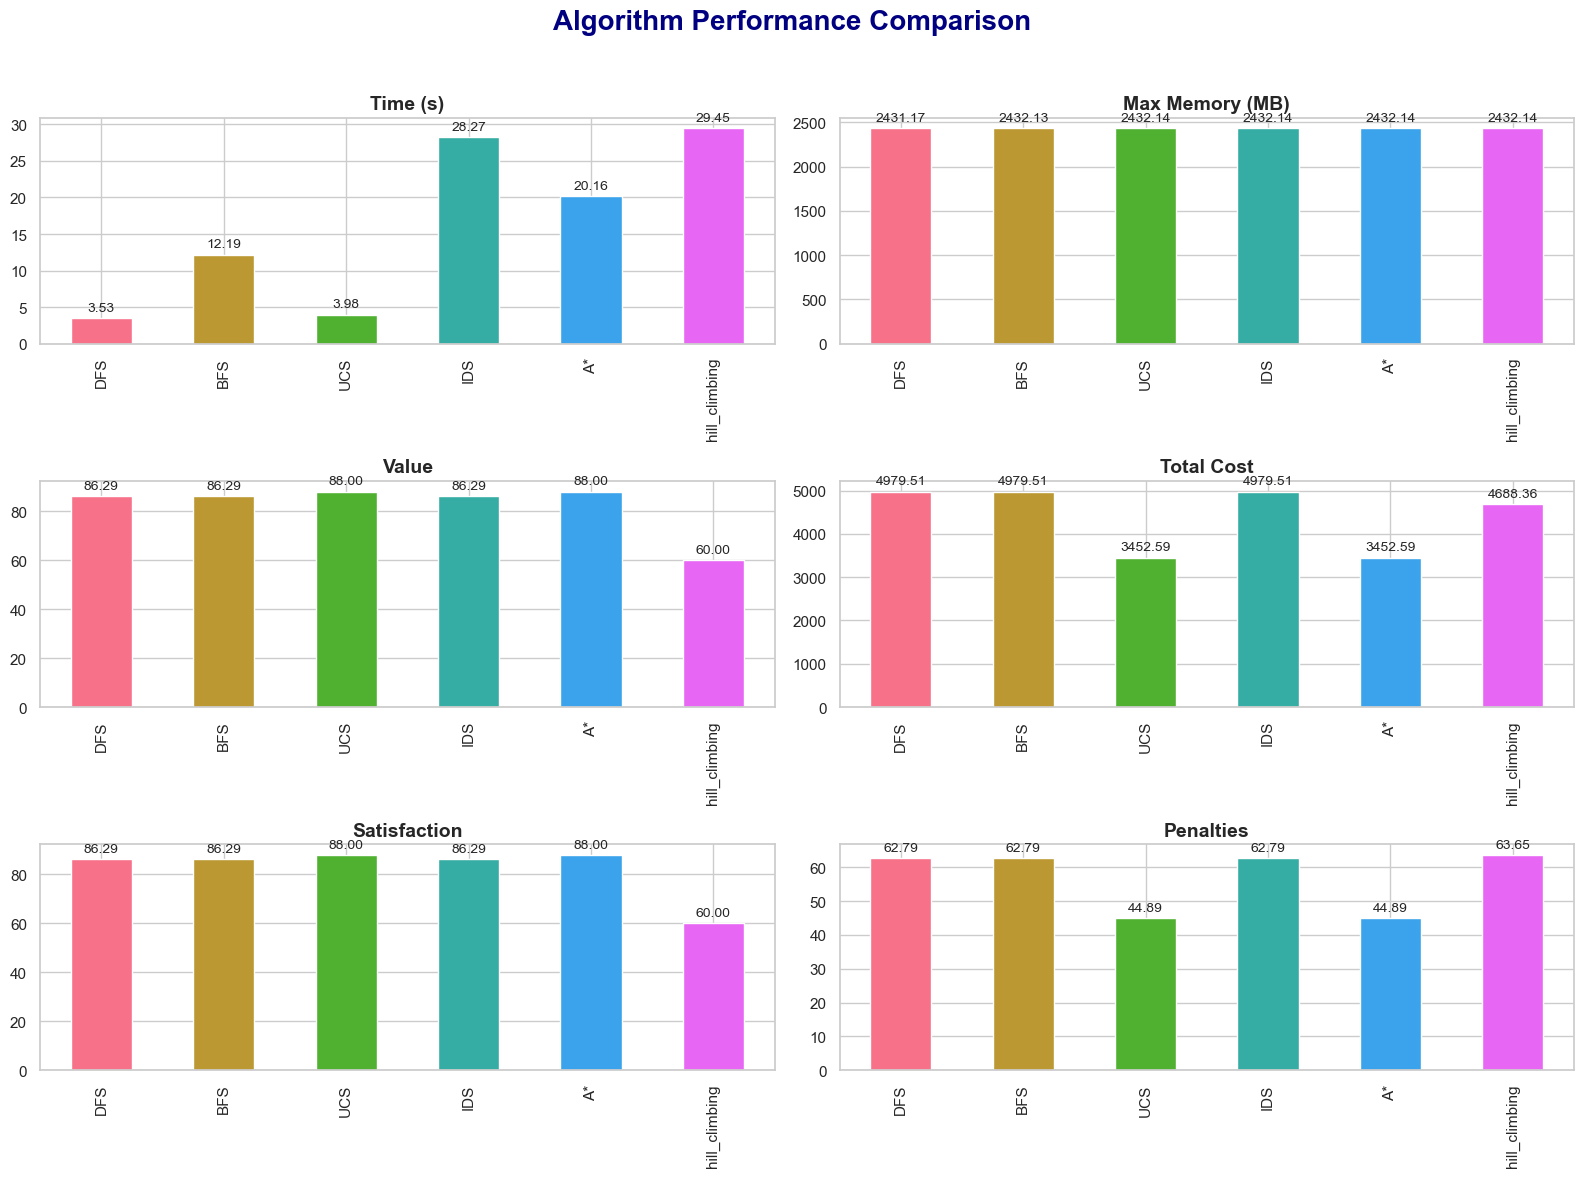

──────────────────────────────────────── 🧠 Algorithm Complexity Analysis ─────────────────────────────────────────

╒═════════════════════╤═══════════════════╤════════════════════╤═══════════╤════════════╕
│ Algorithm           │ Time Complexity   │ Space Complexity   │ Optimal   │ Complete   │
╞═════════════════════╪═══════════════════╪════════════════════╪═══════════╪════════════╡
│ BFS                 │ O(b^d)            │ O(b^d)             │ Yes       │ Yes        │
├─────────────────────┼───────────────────┼────────────────────┼───────────┼────────────┤
│ DFS                 │ O(b^m)            │ O(bm)              │ No        │ No         │
├─────────────────────┼───────────────────┼────────────────────┼───────────┼────────────┤
│ Iterative Deepening │ O(b^d)            │ O(bd)              │ Yes       │ Yes        │
├─────────────────────┼───────────────────┼────────────────────┼───────────┼────────────┤
│ Uniform Cost        │ O(b^(1+C/ε))      │ O(b^(1+C/ε))       │ Yes       │ Yes        │
├─────────────────────┼───────────────────┼────────────────────┼───────────┼────────────┤
│ A*      

──────────────────────────────────────────── 📈 Radar Chart Comparison ────────────────────────────────────────────

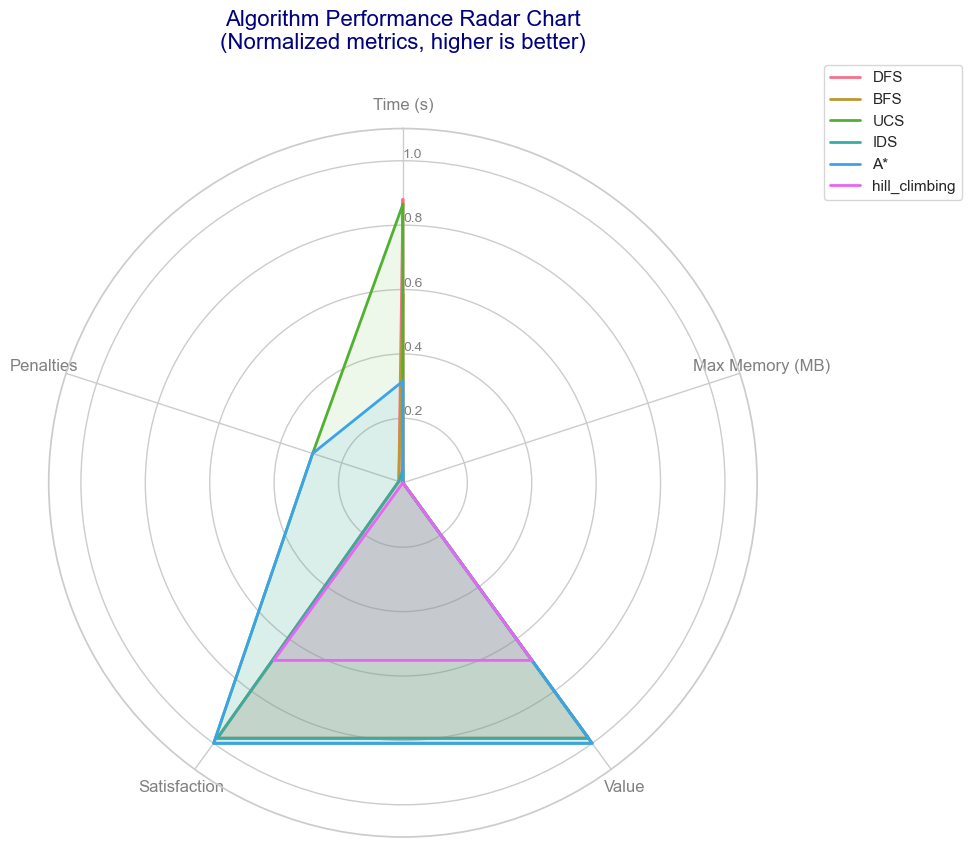

─────────────────────────────────────────── 💡 Strengths and Weaknesses ───────────────────────────────────────────

╒═════════════════════╤═════════════════════════════════════════════════╤════════════════════════════════════════════╤═══════════════════════════════════════════════════════════╕
│                     │ Strengths                                       │ Weaknesses                                 │ Best Use Case                                             │
╞═════════════════════╪═════════════════════════════════════════════════╪════════════════════════════════════════════╪═══════════════════════════════════════════════════════════╡
│ BFS                 │ Guarantees optimal solution, complete           │ High memory usage, slow for large problems │ Small problems where optimality is critical               │
├─────────────────────┼─────────────────────────────────────────────────┼────────────────────────────────────────────┼───────────────────────────────────────────────────────────┤
│ DFS                 │ Low memory usage, fast for some problems        │ Not optimal, may get stuck in d

─────────────────────────────── 📚how each Search Algorithm works in Tour Planning ────────────────────────────────

This section provides a formal discussion of how each search algorithm operates within the context of the tour 
planning problem, where the goal is to optimize an itinerary given constraints (budget, time, preferences).

## 1. Breadth-First Search (BFS)
BFS explores all nodes at the present depth level before moving to nodes at the next depth. It uses a queue to 
manage frontier nodes.

### Application to Tour Planning
- Optimality: Guarantees the shortest path if all steps have equal cost
- Completeness: Always finds a solution if one exists
- Limitations: High memory usage (O(b^d)), impractical for large datasets

## 2. Depth-First Search (DFS)
DFS explores as far as possible along a branch before backtracking, using a stack (LIFO).

### Application to Tour Planning
- Memory Efficiency: Only stores current path (O(bm))
- Drawbacks: Not optimal, may find suboptimal solutions
- Risk: Can get stuck in deep paths without finding better solutions

## 3. Iterative Deepening Search (IDS)
Combines BFS and DFS by performing DFS with incrementally increasing depth limits.

### Application to Tour Planning
- Optimality: Like BFS, guarantees shortest path
- Memory Efficiency: Only stores nodes at current depth (O(bd))
- Trade-off: Repeats work but avoids memory explosion

## 4. Uniform Cost Search (UCS)
Prioritizes nodes with lowest path cost using a priority queue.

### Application to Tour Planning
- Optimality: Guarantees lowest-cost itinerary
- Complexity: O(b^(1+C/ε)) where C is optimal cost
- Best for: Cost-sensitive planning with varying attraction costs

## 5. A* Search
Extends UCS with heuristic function (h(n)) to estimate remaining cost.

### Application to Tour Planning
- Heuristic Example: (remaining_budget / max_cost_per_attraction)
- Optimality: Guaranteed with admissible heuristic
- Efficiency: Explores fewer nodes than UCS with good heuristic

## 6. Hill Climbing (with Restarts)
Local search that moves to neighboring states with higher value.

### Application to Tour Planning
- Strengths: Low memory (O(1)), fast convergence
- Weaknesses: Gets stuck in local optima
- Best for: Large problems where near-optimal is acceptable

In [159]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from memory_profiler import memory_usage
import numpy as np
from tabulate import tabulate
from rich.console import Console
import seaborn as sns
import sys
import io

def generate_academic_report():
    """Generate a formal academic analysis of the algorithms' performance in tour planning."""
    console.rule("[bold blue]📚how each Search Algorithm works in Tour Planning")
    
    analysis = """
This section provides a formal discussion of how each search algorithm operates within the context of the tour planning problem, where the goal is to optimize an itinerary given constraints (budget, time, preferences).

## 1. Breadth-First Search (BFS)
BFS explores all nodes at the present depth level before moving to nodes at the next depth. It uses a queue to manage frontier nodes.

### Application to Tour Planning
- Optimality: Guarantees the shortest path if all steps have equal cost
- Completeness: Always finds a solution if one exists
- Limitations: High memory usage (O(b^d)), impractical for large datasets

## 2. Depth-First Search (DFS)
DFS explores as far as possible along a branch before backtracking, using a stack (LIFO).

### Application to Tour Planning
- Memory Efficiency: Only stores current path (O(bm))
- Drawbacks: Not optimal, may find suboptimal solutions
- Risk: Can get stuck in deep paths without finding better solutions

## 3. Iterative Deepening Search (IDS)
Combines BFS and DFS by performing DFS with incrementally increasing depth limits.

### Application to Tour Planning
- Optimality: Like BFS, guarantees shortest path
- Memory Efficiency: Only stores nodes at current depth (O(bd))
- Trade-off: Repeats work but avoids memory explosion

## 4. Uniform Cost Search (UCS)
Prioritizes nodes with lowest path cost using a priority queue.

### Application to Tour Planning
- Optimality: Guarantees lowest-cost itinerary
- Complexity: O(b^(1+C/ε)) where C is optimal cost
- Best for: Cost-sensitive planning with varying attraction costs

## 5. A* Search
Extends UCS with heuristic function (h(n)) to estimate remaining cost.

### Application to Tour Planning
- Heuristic Example: (remaining_budget / max_cost_per_attraction)
- Optimality: Guaranteed with admissible heuristic
- Efficiency: Explores fewer nodes than UCS with good heuristic

## 6. Hill Climbing (with Restarts)
Local search that moves to neighboring states with higher value.

### Application to Tour Planning
- Strengths: Low memory (O(1)), fast convergence
- Weaknesses: Gets stuck in local optima
- Best for: Large problems where near-optimal is acceptable

"""
    
    console.print(analysis, style="bold white")


def run_algorithm(algorithm, problem):
    """Run an algorithm and measure its performance metrics."""
    start_time = time.time()

    # Define a wrapper to correctly call the algorithm with proper args
    def wrapped_algo():
        if algorithm.__name__ == 'BFS':
            return algorithm(problem, hotels_data, attractions_data)
        elif algorithm.__name__ in ['depth_first_search', 'iterative_deepening_search']:
            return algorithm(problem, max_depth=40)
        else:
            return algorithm(problem)

    if algorithm.__name__ == 'hill_climbing':
        # 🌟 Silence hill climbing output
        sys_stdout = sys.stdout
        sys.stdout = io.StringIO()

        try:
            # Profile memory usage
            mem_usage = memory_usage((wrapped_algo,), interval=0.1)
            avg_mem = sum(mem_usage) / len(mem_usage)
            max_mem = max(mem_usage)
            solution = wrapped_algo()
        finally:
            sys.stdout = sys_stdout  # Restore normal stdout

    else:
        # Normal for other algorithms
        mem_usage = memory_usage((wrapped_algo,), interval=0.1)
        avg_mem = sum(mem_usage) / len(mem_usage)
        max_mem = max(mem_usage)
        solution = wrapped_algo()

    exec_time = time.time() - start_time

    if solution:
        if algorithm.__name__ == 'hill_climbing':
            solution_state = solution[0] if isinstance(solution, tuple) else solution
            return {
                'solution': solution,
                'time': exec_time,
                'avg_memory': avg_mem,
                'max_memory': max_mem,
                'cost': solution_state['total_cost'],
                'days_used': solution_state['curr_day'],
                'satisfaction': problem._calculate_satisfaction(solution_state),
                'penalties': problem._calculate_penalties(solution_state),
                'value': problem.value(solution_state),
                'nodes_expanded': None,
                'frontier_size': None
            }
        else:
            return {
                'solution': solution,
                'time': exec_time,
                'avg_memory': avg_mem,
                'max_memory': max_mem,
                'cost': solution.state['total_cost'],
                'days_used': solution.state['curr_day'],
                'satisfaction': problem._calculate_satisfaction(solution.state),
                'penalties': problem._calculate_penalties(solution.state),
                'value': problem.value(solution.state),
                'nodes_expanded': getattr(solution, 'nodes_expanded', None),
                'frontier_size': getattr(solution, 'max_frontier', None)
            }
    return None


console = Console()

def compare_algorithms(attractions_data):
    """Compare multiple algorithms for the tour planning problem with modern visuals."""
    constraints = {
        "max_total_budget": 5000.0,
        "max_daily_time": 8.0,
        "max_attractions_per_day": 1,
        "has_car": True,
    }
    user_prefs = {"categories": ["Museum"]}

    initial_state = {
        "current_location": (36.746784556962844, 3.069475072334992),   # Maqam Echahid
        "itinerary": [[] for _ in range(7)],
        "curr_day": 0,
        "total_cost": 0.0,
        "total_time": 0.0,
        "daily_time": [0.0] * 7,
        'daily_distance': [0.0]*7
    }

    # Build problem
    problem = TourPlanningProblem(
        initial_state=initial_state,
        attractions=attractions_data,
        user_prefs=user_prefs,
        constraints=constraints
    )

    algorithms = [
        ('DFS', depth_first_search),
        ('BFS', BFS),
        ('UCS', uniform_cost_search),
        ('IDS', iterative_deepening_search),
        ('A*', a_star_search),
        ('hill_climbing', steepest_ascent_hc_with_restarts)
    ]

    results = []
    print("Running comparisons...")
    for name, algo in algorithms:
        print(f"\n{name}...")
        result = run_algorithm(algo, problem)
        if result:
            results.append({
                'Algorithm': name,
                'Time (s)': result['time'],
                'Avg Memory (MB)': result['avg_memory'],
                'Max Memory (MB)': result['max_memory'],
                'Total Cost': result['cost'],
                'Days Used': result['days_used'],
                'Satisfaction': result['satisfaction'],
                'Penalties': result['penalties'],
                'Value': result['value'],
            })
        else:
            results.append({
                'Algorithm': name,
                'Time (s)': np.nan,
                'Avg Memory (MB)': np.nan,
                'Max Memory (MB)': np.nan,
                'Total Cost': np.nan,
                'Days Used': np.nan,
                'Satisfaction': np.nan,
                'Penalties': np.nan,
                'Value': np.nan,
            })

    # Create DataFrame
    df = pd.DataFrame(results).set_index('Algorithm')

    # 🌟 Modern Table Display
    console.rule("[bold cyan]📊 Results Table")
    print(tabulate(df.round(2), headers='keys', tablefmt='fancy_grid'))

    # Plotting
    numeric_columns = ['Time (s)', 'Max Memory (MB)', 'Value', 'Total Cost', 'Satisfaction', 'Penalties']
    
    if df[numeric_columns].dropna(how='all').empty:
        console.print("\n[bold red]⚠️ No valid numeric data to plot.[/bold red]")
        return

    sns.set_theme(style="whitegrid")
    custom_palette = sns.color_palette("husl", len(df))

    # Main performance metrics plot - now with 6 subplots (3 rows × 2 columns)
    fig, axes = plt.subplots(3, 2, figsize=(16, 12))
    axes = axes.flatten()  # Flatten the 3x2 array of axes for easier iteration

    for i, metric in enumerate(numeric_columns):
        ax = axes[i]
        df[metric].plot(kind='bar', ax=ax, color=custom_palette)
        ax.set_title(metric, fontsize=14, fontweight='bold')
        ax.set_xlabel("")
        
        # Add value labels on top of bars
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(p.get_x() + p.get_width() / 2., height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)

    # Hide any empty subplots if we have an odd number
    if len(numeric_columns) < len(axes):
        for j in range(len(numeric_columns), len(axes)):
            axes[j].axis('off')

    plt.suptitle("Algorithm Performance Comparison", fontsize=20, fontweight='bold', color='navy')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    
    
    # Add value labels on top of bars
   

    # 🌟 Algorithm Complexity Analysis
    console.rule("[bold green]🧠 Algorithm Complexity Analysis")
    complexity_data = {
        'Algorithm': ['BFS', 'DFS', 'Iterative Deepening', 'Uniform Cost', 'A*', 'Hill Climbing'],
        'Time Complexity': ['O(b^d)', 'O(b^m)', 'O(b^d)', 'O(b^(1+C/ε))', 'O(b^d)', 'O(n)'],
        'Space Complexity': ['O(b^d)', 'O(bm)', 'O(bd)', 'O(b^(1+C/ε))', 'O(b^d)', 'O(1)'],
        'Optimal': ['Yes', 'No', 'Yes', 'Yes', 'Yes', 'No'],
        'Complete': ['Yes', 'No', 'Yes', 'Yes', 'Yes', 'No']
    }
    complexity_df = pd.DataFrame(complexity_data).set_index('Algorithm')
    print(tabulate(complexity_df, headers='keys', tablefmt='fancy_grid'))
    
    # 🌟 Radar Chart Visualization
    console.rule("[bold purple]📈 Radar Chart Comparison")
    
    # Select metrics for radar chart (normalized to 0-1 scale)
    radar_metrics = ['Time (s)', 'Max Memory (MB)', 'Value', 'Satisfaction', 'Penalties']
    radar_df = df[radar_metrics].copy()
    
    # Normalize data (lower time/memory is better, higher value/satisfaction is better, lower penalties is better)
    for metric in radar_metrics:
        if metric in ['Time (s)', 'Max Memory (MB)', 'Penalties']:
            radar_df[metric] = 1 - (radar_df[metric] / radar_df[metric].max())
        else:
            radar_df[metric] = radar_df[metric] / radar_df[metric].max()
    
    # Number of variables we're plotting
    categories = list(radar_df.columns)
    N = len(categories)
    
    # Calculate angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    # Initialize radar chart
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # Set the first axis to be on top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    plt.ylim(0, 1.1)
    
    # Plot each algorithm
    colors = sns.color_palette("husl", len(radar_df))
    for idx, (algo, row) in enumerate(radar_df.iterrows()):
        values = row.values.flatten().tolist()
        values += values[:1]  # Complete the loop
        ax.plot(angles, values, color=colors[idx], linewidth=2, linestyle='solid', label=algo)
        ax.fill(angles, values, color=colors[idx], alpha=0.1)
    
    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title("Algorithm Performance Radar Chart\n(Normalized metrics, higher is better)", 
              size=16, color='navy', y=1.1)
    
    plt.tight_layout()
    plt.show()
    
    # 🌟 Strengths and Weaknesses
    console.rule("[bold yellow]💡 Strengths and Weaknesses")
    analysis = {
        'BFS': {
            'Strengths': 'Guarantees optimal solution, complete',
            'Weaknesses': 'High memory usage, slow for large problems',
            'Best Use Case': 'Small problems where optimality is critical'
        },
        'DFS': {
            'Strengths': 'Low memory usage, fast for some problems',
            'Weaknesses': 'Not optimal, may get stuck in deep paths',
            'Best Use Case': 'When memory is constrained and solution depth is known'
        },
        'Iterative Deepening': {
            'Strengths': 'Optimal like BFS but with better memory usage',
            'Weaknesses': 'Repeats work at each iteration',
            'Best Use Case': 'When solution depth is unknown but optimality is needed'
        },
        'Uniform Cost': {
            'Strengths': 'Optimal for path cost, good for weighted graphs',
            'Weaknesses': 'Higher memory usage than greedy algorithms',
            'Best Use Case': 'When costs vary significantly between steps'
        },
        'A*': {
            'Strengths': 'Optimal and efficient with good heuristic',
            'Weaknesses': 'Requires domain-specific heuristic',
            'Best Use Case': 'When you have a good heuristic function'
        },
        'Hill Climbing': {
            'Strengths': 'Very fast, low memory usage',
            'Weaknesses': 'Gets stuck in local optima, not optimal',
            'Best Use Case': 'Large problems where a good-enough solution is acceptable'
        }
    }
    analysis_df = pd.DataFrame(analysis).T
    print(tabulate(analysis_df, headers='keys', tablefmt='fancy_grid'))
    generate_academic_report()

attractions_data = load_attractions("../Data/attractions.json")
compare_algorithms(attractions_data)


## Visualizations

We will include several visualizations to help understand the results:
- **Route Map**: Visualize the itinerary on a map.
- **Cost Breakdown**: Graph showing the total cost per destination.
- **Satisfaction**: Bar chart comparing user satisfaction for different search strategies.


In [157]:
import matplotlib.pyplot as plt

# Example plot for the cost breakdown
def plot_cost_breakdown(itinerary, attractions):
    costs = [attractions[a]['cost'] for a in itinerary]
    plt.bar(range(len(itinerary)), costs)
    plt.xlabel('Attraction')
    plt.ylabel('Cost')
    plt.title('Cost Breakdown')
    plt.show()

## Demo

In this section, we will showcase the working prototype of the **7wess Touristic Tour Recommendation Application**. This demo will cover:
- The **interactive input** from the user (e.g., preferences, current location, etc.).
- Displaying the **optimized itinerary** generated by the selected search algorithm.
- Visualizations of the **travel route**, **cost breakdown**, and **satisfaction level**.

In [ ]:
import json
from collections import Counter
%pip install folium
import folium

# Load data
with open("../Data/attractions.json", "r", encoding="utf-8") as f:
    attractions_data = json.load(f)
with open("../Data/cleaned_hotels.json", "r", encoding="utf-8") as f:
    hotels_data = json.load(f)

# ─── Helper Functions ─────────────────────────────────────────────────────────

def get_user_choice(options, prompt, multi=False):
    print(prompt)
    for i, opt in enumerate(options, 1):
        print(f"  {i}. {opt}")
    while True:
        choice = input("Enter number(s), comma-separated: " if multi else "Enter number: ")
        try:
            if multi:
                idxs = [int(x.strip()) for x in choice.split(",")]
                return [options[i-1] for i in idxs]
            else:
                return options[int(choice)-1]
        except:
            print("❌ Invalid input, please try again.")

def get_float(prompt, default=None):
    while True:
        try:
            s = input(prompt)
            if default is not None and s.strip()=="":
                return default
            return float(s)
        except:
            print("❌ Enter a valid number.")

def get_int(prompt, default=None):
    while True:
        try:
            s = input(prompt)
            if default is not None and s.strip()=="":
                return default
            return int(s)
        except:
            print("❌ Enter a valid integer.")

def get_coord(prompt):
    while True:
        try:
            lat, lon = input(prompt).split(",")
            return (float(lat.strip()), float(lon.strip()))
        except:
            print("❌ Enter as lat,lon (e.g. 36.737232,3.086472)")

# ─── Collect User Inputs ──────────────────────────────────────────────────────

print("🎒 Welcome to the Algeria Trip Planner Demo!\n")

start_loc = get_coord("🌍 Enter your starting location (lat,lon): ")

all_cats = sorted({a['category'] for a in attractions_data})
selected_cats = get_user_choice(
    all_cats,
    "\n🎯 Select preferred attraction categories (choose multiple):",
    multi=True
)

budget = get_float("\n💰 Enter total budget (DZD): ")
max_daily_time = get_float("⏱️  Enter max daily time (hours, default 8): ", default=8.0)
max_per_day = get_int("📅 Enter max attractions per day (default 3): ", default=3)

has_car = input("\n🚗 Will you have a car? (y/n): ").lower().startswith("y")

min_star = get_int("\n🏨 Enter minimum hotel stars (1–5): ")
max_star = get_int("🏨 Enter maximum hotel stars (1–5): ")

algos = [
    "Depth‑First Search (DFS)",
    "Breadth‑First Search (BFS)",
    "Uniform Cost Search (UCS)",
    "A* Search",
    "Hill Climbing",
    "Stochastic Hill Climbing",
    "Constraint Programming (CSP)"
]
algo = get_user_choice(algos, "\n🔍 Choose search algorithm:")

# ─── Build Problem ────────────────────────────────────────────────────────────

constraints = {
    "max_total_budget":       budget,
    "max_daily_time":         max_daily_time,
    "max_attractions_per_day":max_per_day,
    "has_car":                has_car,
}
user_prefs = {
    "categories":  selected_cats,
    "hotel_stars": (min_star, max_star),
}

initial_state = {
    "current_location": start_loc,
    "itinerary": [[] for _ in range(7)],
    "curr_day": 0,
    "total_cost": 0.0,
    "total_time": 0.0,
    "daily_time": [0.0]*7,
    "daily_distance": [0.0]*7,
    "preferences": user_prefs,
}

problem = TourPlanningProblem(
    initial_state=initial_state,
    attractions=attractions_data,
    user_prefs=user_prefs,
    constraints=constraints,
)

# ─── Solve ───────────────────────────────────────────────────────────────────

if "DFS" in algo:
    sol = depth_first_search(problem)
elif "BFS" in algo:
    sol = BFS(problem, hotels_data, attractions_data)
elif "UCS" in algo:
    sol = uniform_cost_search(problem)
elif "A*" in algo:
    sol = a_star_search(problem)
elif "Stochastic" in algo:
    sol = stochastic_hill_climbing_with_restarts(problem)
elif "Hill Climbing" in algo:
    sol = steepest_ascent_hc_with_restarts(problem)
else:
    from ortools.sat.python import cp_model
    csp = TourCSP(
        start_location=start_loc,
        attractions=attractions_data,
        hotels=hotels_data,
        user_prefs=user_prefs,
        constraints=constraints,
    )
    status = csp.solve(time_limit=30)
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        itin = csp.decode_itinerary()
        total = sum(problem._parse_cost(a['cost'])
                    for day in itin
                    for a in attractions_data if a["name"] in day)
        sol = type("G", (), {"state": {"itinerary": itin, "total_cost": total}})()
    else:
        sol = None

# ─── Print & Map ─────────────────────────────────────────────────────────────

def render_and_print(goal):
    if not goal:
        print("\n❌ No valid itinerary found. Try relaxing constraints.")
        return

    print("\n✨ Your Optimized Itinerary ✨")
    print("─"*60)
    here = start_loc
    rate = 6 if has_car else 10

    # Prepare Folium map
    m = folium.Map(location=start_loc, zoom_start=7)
    colors = ['red','blue','green','purple','orange','darkred','cadetblue']

    # Plot each day's visits
    for day_idx, visits in enumerate(goal.state["itinerary"], 1):
        if not visits: continue
        coords = [here]
        for name in visits:
            att = next(a for a in attractions_data if a["name"]==name)
            coords.append(att["gps"])
        coords.append(start_loc)  # back to start each day
        # line
        folium.PolyLine(coords, color=colors[(day_idx-1)%len(colors)],
                        weight=4, opacity=0.6,
                        tooltip=f"Day {day_idx}").add_to(m)
        # markers
        for pt in coords[1:-1]:
            folium.CircleMarker(pt, radius=5,
                                color=colors[(day_idx-1)%len(colors)],
                                fill=True).add_to(m)
        here = start_loc

        # textual print
        day_cost = 0.0
        print(f"\n📅 Day {day_idx}:")
        for name in visits:
            att = next(a for a in attractions_data if a["name"]==name)
            dist = problem._calculate_distance(here, att["gps"])
            tcost = dist*rate + problem._parse_cost(att["cost"])
            day_cost += tcost
            print(f"  ➜ {name} ({dist:.1f}km, {tcost:.0f} DZD)")
            here = att["gps"]
        print(f"🧮 Day {day_idx} Total: {day_cost:.0f} DZD")
        print("─"*60)

    # hotels (same as before)
    hotels_by_day = find_hotels_for_itinerary(
        goal.state["itinerary"],
        attractions_data, hotels_data,
        budget, goal.state["total_cost"],
        min_star, max_star
    )
    print("\n🏨 Hotels Suggestions")
    print("─"*60)
    for d, hs in hotels_by_day.items():
        print(f"Day {d}:")
        for h in hs[:2]:
            print(f"  ★ {h['hotel']} — {h['avg_review']}⭐ @ {h['price']} DZD/night")
        if not hs: print("  (none)")

    print("\n🌟 Trip Summary 🌟")
    print("─"*60)
    print(f"🎫 Attractions cost: {goal.state['total_cost']:.0f} DZD")
    print(f"💰 Remaining for hotels: {(budget-goal.state['total_cost']):.0f} DZD")
    display(m)  # show map inline

# Execute
render_and_print(sol)

🎒 Welcome to the Algeria Trip Planner Demo!


🎯 Select preferred attraction categories (choose multiple):
  1. Amusement Park
  2. Beach
  3. Cultural
  4. Garden
  5. Historical
  6. Lake
  7. Museum
  8. Nature
  9. Port
  10. Religious
  11. Resort
  12. Shopping Mall

🔍 Choose search algorithm:
  1. Depth‑First Search (DFS)
  2. Breadth‑First Search (BFS)
  3. Uniform Cost Search (UCS)
  4. A* Search
  5. Hill Climbing
  6. Stochastic Hill Climbing
  7. Constraint Programming (CSP)

✨ Your Optimized Itinerary ✨
────────────────────────────────────────────────────────────

📅 Day 1:
  ➜ Casbah of Algiers (4.3km, 26 DZD)
🧮 Day 1 Total: 26 DZD
────────────────────────────────────────────────────────────

📅 Day 2:
  ➜ Martyrs' Memorial (Maqam Echahid) (3.0km, 18 DZD)
🧮 Day 2 Total: 18 DZD
────────────────────────────────────────────────────────────

📅 Day 3:
  ➜ Tipaza Roman Ruins (50.1km, 701 DZD)
🧮 Day 3 Total: 701 DZD
────────────────────────────────────────────────────────────

📅 Da

## Conclusion

In this notebook, we explored different search algorithms (A\*, Hill Climbing, BFS, DFS) and a CSP approach to generate optimal itineraries for travelers in Algeria. 
We found that **.....** performed well in terms of solution quality, but it was more computationally expensive compared to **.....**. 
Future work could involve integrating real-time weather data and optimizing routes based on current traffic conditions.
